<a href="https://colab.research.google.com/github/javmencia/STA410/blob/main/STA410FP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proposal:
## Variational Inference for Large-Scale Bayesian Models

### Objective:
This project will explore variational inference (VI) as a scalable alternative to Markov Chain Monte Carlo (MCMC) for fitting Bayesian models. The focus will be on implementing VI for Bayesian regression and comparing its performance to traditional MCMC methods.

### Why This Project?

MCMC can be computationally expensive for high-dimensional models, making VI a valuable alternative.
VI is widely used in machine learning applications, such as deep generative models.
Offers insights into trade-offs between accuracy, speed, and interpretability in Bayesian modeling.
Methods & Implementation:

Implement Bayesian linear regression using both MCMC (e.g., Hamiltonian Monte Carlo) and VI.
Use PyMC or TensorFlow Probability for variational inference.
Compare convergence speed, model fit, and uncertainty quantification.
Extend to more complex models (e.g., Bayesian logistic regression) if time permits

Methods & Implementation
The project will cover the following steps:

1. Implement Bayesian Linear Regression (Baseline Model)

Use PyMC and TensorFlow Probability to implement Bayesian linear regression.
Compare inference results using MCMC (Hamiltonian Monte Carlo) and Variational Inference (ADVI and Mean-Field VI).
Evaluate model performance based on convergence diagnostics, model fit, and uncertainty quantification.
2. Extend to Bayesian Logistic Regression

Implement Bayesian logistic regression using MCMC and VI to handle binary classification problems.
Investigate how inference methods handle classification uncertainty.
3. Explore Hierarchical Bayesian Models

Implement a hierarchical model where parameters share distributions across multiple groups (e.g., multi-level regression).
Compare MCMC vs. VI performance in handling hierarchical structure and information pooling.
4. Introduce Sparsity with Bayesian Regularization

Implement Bayesian Ridge Regression and Sparse Bayesian Learning.
Explore Automatic Relevance Determination (ARD) to shrink unnecessary coefficients to zero.
Compare how MCMC and VI perform in handling sparse priors.
5. Expand to Deep Bayesian Models (Optional Advanced Step)

Apply Bayesian Neural Networks (BNNs) for uncertainty-aware deep learning.
Use Bayesian Dropout and Bayesian Variational Layers to model uncertainty in deep networks.
Compare the computational cost of VI vs. MCMC in deep Bayesian models.
Evaluation Metrics
Inference Speed: Compare runtime performance for MCMC vs. VI.
Convergence Diagnostics: Use Gelman-Rubin statistic and trace plots to check MCMC convergence; assess ELBO (Evidence Lower Bound) for VI.
Prediction Uncertainty: Compare posterior credible intervals.
Model Fit: Use Bayesian R², WAIC, and Bayes Factor to evaluate model performance.
Real-World Applications & Case Studies
Finance: Predicting stock returns with Bayesian regression.
Healthcare: Bayesian modeling of disease risk factors.
Natural Language Processing (NLP): Bayesian topic modeling with Latent Dirichlet Allocation (LDA).

In [4]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import pandas as pd


## Model set-up

In [5]:
# Bayesian Linear Regression Model
def bayesian_regression_mcmc(X, y, true_beta  = None):
    if true_beta is None:
        true_beta = np.zeros(X.shape[1])
    with pm.Model() as model:
        # Priors
        beta = pm.MvNormal("beta", mu=true_beta, chol=np.eye(X.shape[1]), shape=X.shape[1])
        sigma = pm.HalfCauchy("sigma", beta=2)  # Prior on error term

        # Likelihood
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

        # Sample from the posterior using MCMC
        trace = pm.sample(4000, return_inferencedata=True,
                          idata_kwargs={"log_likelihood": True})  # Ensure log likelihood is stored

    return model, trace

# Bayesian Ridge Regression Model
def bayesian_ridge_regression(X, y, true_beta  = None):
    if true_beta is None:
        true_beta = np.zeros(X.shape[1])
    with pm.Model() as model:
        # Prior on precision (1/tau^2) for ridge penalty
        tau = pm.HalfCauchy("tau", beta=1)  # Shrinkage parameter (larger beta = weaker prior)

        # Ridge prior on beta (similar to L2 regularization)
        beta = pm.MvNormal("beta", mu=true_beta, cov=tau**2 * np.eye(X.shape[1]), shape=X.shape[1])

        # Prior on the noise term
        sigma = pm.HalfCauchy("sigma", beta=2)

        # Likelihood
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

        # Sample from the posterior using MCMC
        trace = pm.sample(4000, return_inferencedata=True,
                          idata_kwargs={"log_likelihood": True})
    return model, trace


# Bayesian Robust Regression Model
def bayesian_robust_regression(X, y, true_beta  = None):
    if true_beta is None:
        true_beta = np.zeros(X.shape[1])
    with pm.Model() as model:
        beta = pm.MvNormal("beta", mu=true_beta, chol=np.eye(X.shape[1]), shape=X.shape[1])
        sigma = pm.HalfCauchy("sigma", beta=2)
        nu = pm.Exponential("nu", 1/30)  # Degrees of freedom for the Student-T

        mu = pm.math.dot(X, beta)
        y_obs = pm.StudentT("y_obs", nu=nu, mu=mu, sigma=sigma, observed=y)

        trace = pm.sample(4000, return_inferencedata=True,
                          idata_kwargs={"log_likelihood": True})

    return model, trace

def bayesian_regression_vi(X, y, true_beta = None):
    if true_beta is None:
        true_beta = np.zeros(X.shape[1])
    with pm.Model() as model:
        beta = pm.MvNormal("beta", mu=true_beta, chol=np.eye(X.shape[1]), shape=X.shape[1])
        sigma = pm.HalfCauchy("sigma", beta=2)
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        approx = pm.fit(n=10000, method="advi")  # Automatic Differentiation Variational Inference (ADVI)
    return model, approx.sample(1000)

def bayesian_pcr(X, y, true_beta=None, n_components=None):
    if true_beta is None:
        true_beta = np.zeros(X.shape[1])

    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)  # Shape (n, n_components)

    with pm.Model() as model:
        # Priors on regression coefficients in PCA space
        beta = pm.MvNormal("beta", mu=np.zeros(X_pca.shape[1]), chol=np.eye(X_pca.shape[1]), shape=X_pca.shape[1])
        sigma = pm.HalfCauchy("sigma", beta=2)

        # Likelihood
        mu = pm.math.dot(X_pca, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

        # Sample from the posterior
        trace = pm.sample(4000, return_inferencedata=True, idata_kwargs={"log_likelihood": True})

    return model, trace, pca  # Return PCA object for inverse transformation



## Plot models

In [3]:
def run_and_plot_models(X, y, true_beta):
    """
    Runs multiple Bayesian regression models and plots the posterior distributions of beta coefficients.

    Parameters:
        X (array-like): Feature matrix
        y (array-like): Response variable
        true_beta (array-like): True beta coefficients for comparison
    """
    # Run all models
    models = {
        "Bayesian Linear Regression": bayesian_regression_mcmc(X, y, true_beta),
        "Bayesian Ridge Regression": bayesian_ridge_regression(X, y, true_beta),
        "Bayesian Robust Regression": bayesian_robust_regression(X, y, true_beta),
        "Bayesian Variational Inference": bayesian_regression_vi(X, y, true_beta),
        "Bayesian Principal Component Regression": bayesian_pcr(X, y, true_beta, n_components=2)
    }

    fig, axes = plt.subplots(len(true_beta), 5, figsize=(18, 12))

    for col, (model_name, (model, trace)) in enumerate(models.items()):
        for i in range(len(true_beta)):  # Assuming 3 beta coefficients
            az.plot_posterior(trace, var_names=["beta"], hdi_prob=0.95, ax=axes[i, col], rope=(-1, 1))
            axes[i, col].set_title(f"{model_name} - beta[{i}]")
            axes[i, col].set_xlim(-1, 1)

    plt.suptitle("Posterior Distributions for All Models", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

def compute_rmse(trace, X, y):
    """Computes RMSE using posterior predictive means."""
    beta_samples = trace.posterior["beta"].mean(dim=["chain", "draw"]).values
    y_pred = X @ beta_samples
    return np.sqrt(np.mean((y - y_pred) ** 2))

def run_and_plot_models(X, y, true_beta, n_components=2):
    models = [bayesian_regression_mcmc, bayesian_ridge_regression, bayesian_robust_regression, bayesian_regression_vi, bayesian_pcr]
    model_names = ["Bayesian Linear Regression", "Bayesian Ridge Regression", "Bayesian Robust Regression", "Bayesian Regression VI", "Bayesian PCR"]
    for model, name in zip(models, model_names):
        print(f"Running {name}...")
        if name == "Bayesian PCR":
            mod, trace = model(X, y, true_beta, n_components)
        else:
            mod, trace = model(X, y, true_beta)

        pm.plot_posterior(trace, var_names=["beta"])
        plt.suptitle(f"Posterior Distributions for {name}")
        plt.show()

In [6]:
def compute_rmse(trace, X, y, pca=None):
    beta_key = [key for key in trace.posterior.keys() if "beta" in key][0]
    beta_samples = trace.posterior[beta_key].mean(dim=["chain", "draw"]).values

    if pca is not None:  # Convert PCR coefficients back to original feature space
        beta_samples = pca.components_.T @ beta_samples  # Shape (5, 2) @ (2,) -> (5,)

    y_pred = X @ beta_samples  # Now beta_samples has correct shape (5,)
    return np.sqrt(np.mean((y - y_pred) ** 2)), beta_samples


def run_and_plot_models(X, y, true_beta, n_components=2):
    models = {
        "Bayesian Linear Regression": bayesian_regression_mcmc,
        "Bayesian Ridge Regression": bayesian_ridge_regression,
        "Bayesian Robust Regression": bayesian_robust_regression,
        "Bayesian Variational Inference": bayesian_regression_vi,
        "Bayesian Principal Component Regression": lambda X, y, tb: bayesian_pcr(X, y, tb, n_components)
    }

    num_betas = len(true_beta)

    # First figure (exclude PCR from plotting)
    fig, axes = plt.subplots(num_betas, len(models) - 1, figsize=(18, 3 * num_betas), sharex=True, sharey=True)

    results = []

    for col, (model_name, model_func) in enumerate(models.items()):
        print(f"Running {model_name}...")

        if model_name == "Bayesian Principal Component Regression":
            model, trace, pca = model_func(X, y, true_beta)
        else:
            model, trace = model_func(X, y, true_beta)

        rmse, beta_estimates = compute_rmse(trace, X, y, pca if model_name == "Bayesian Principal Component Regression" else None)

        results.append([model_name] + list(beta_estimates) + [rmse])

        # Skip PCR plots in the first figure
        if model_name != "Bayesian Principal Component Regression":
            beta_key = [key for key in trace.posterior.keys() if "beta" in key][0]
            beta_samples = trace.posterior[beta_key]

            for i in range(num_betas):
                az.plot_posterior(beta_samples.sel(beta_dim_0=i), hdi_prob=0.95, ax=axes[i, col])
                axes[i, col].set_title(f"{model_name} - Beta[{i}]")

    plt.suptitle("Posterior Distributions for All Models (Except PCR)", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

    # Second figure: Show number of components, leave rest empty
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.text(0.5, 0.5, f"PCR Components: {n_components}", fontsize=14, ha='center', va='center')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

    # Create and display results table
    columns = ["Model"] + [f"Beta[{i}]" for i in range(num_betas)] + ["RMSE"]
    results_df = pd.DataFrame(results, columns=columns)
    print(results_df)
    return results_df

## Changing parameters

In [4]:
def evaluate_model_performance(estimated_beta, true_beta = None):
    if true_beta is None:
        true_beta = np.zeros(len(estimated_beta))
    return np.sqrt(np.mean((true_beta - estimated_beta) ** 2))  # RMSE

def run_models_and_evaluate(n=20, p=3, true_beta=None, n_components=2):
    if true_beta is None:
        if p is None:
            raise ValueError("Either true_beta or p must be provided.")
        true_beta = np.logspace(0, 1, p, base=2)  # Generate true_beta based on p

    p = len(true_beta)
    sigma_true = 1

    # Generate data
    X = np.ones((n, p))
    for i in range(0, X.shape[1], 2):
        X[i::2, i] = 0
        X[i+1::2, i] = 1

    y = np.dot(X, true_beta) + stats.norm(0, sigma_true).rvs(n)

    # Run models
    _, trace_mcmc = bayesian_regression_mcmc(X, y, true_beta)
    _, trace_ridge = bayesian_ridge_regression(X, y, true_beta)
    _, trace_robust = bayesian_robust_regression(X, y, true_beta)
    _, trace_vi = bayesian_regression_vi(X, y, true_beta)

    # Perform PCA on X
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)  # Project X into PCA space
    _, trace_pcr = bayesian_pcr(X_pca, y, true_beta, n_components)

    # Extract posterior means
    beta_mcmc = trace_mcmc.posterior['beta'].mean(dim=('chain', 'draw')).values
    beta_ridge = trace_ridge.posterior['beta'].mean(dim=('chain', 'draw')).values
    beta_robust = trace_robust.posterior['beta'].mean(dim=('chain', 'draw')).values
    beta_vi = trace_vi.posterior['beta'].mean(dim=('chain', 'draw')).values
    beta_pcr = trace_pcr.posterior['beta'].mean(dim=('chain', 'draw')).values  # In PCA space

    # Convert beta_pcr back to original predictor space
    beta_pcr_original = pca.components_.T @ beta_pcr  # Back-transform to original space

    # Compute RMSE
    rmse_mcmc = evaluate_model_performance(beta_mcmc, true_beta)
    rmse_ridge = evaluate_model_performance(beta_ridge, true_beta)
    rmse_robust = evaluate_model_performance(beta_robust, true_beta)
    rmse_vi = evaluate_model_performance(beta_vi,true_beta)
    rmse_pcr = evaluate_model_performance(beta_pcr_original, true_beta)  # Now in original space

    return rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi, rmse_pcr


## Initial set-up

In [ ]:
np.random.seed(410)
n=50
p = 5
# Create alternating columns of [0, 1] and [1, 0] in 3 columns to reduce experimental randomness
X = np.ones((n, p))
for i in range(0, X.shape[1], 2):
    X[i::2, i] = 0
    X[i+1::2, i] = 1

# Create true_beta based on logspace
true_beta = np.logspace(0, 1, p, base=2)
sigma_true = 1
print(true_beta)

# Generate y with added random noise
y = np.dot(X, true_beta) + stats.norm(0,sigma_true).rvs(n)

run_and_plot_models(X, y, true_beta, n_components=2)

[1.         1.18920712 1.41421356 1.68179283 2.        ]
Running Bayesian Linear Regression...


Output()

Running Bayesian Ridge Regression...


## Changing the sample size

Running models for sample size: 50


Output()

Output()

ERROR:pymc.stats.convergence:There were 256 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Running models for sample size: 100


Output()

Output()

ERROR:pymc.stats.convergence:There were 515 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Output()

Running models for sample size: 500


Output()

Output()

ERROR:pymc.stats.convergence:There were 300 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Running models for sample size: 1000


Output()

Output()

ERROR:pymc.stats.convergence:There were 78 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Running models for sample size: 1500


Output()

Output()

ERROR:pymc.stats.convergence:There were 274 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

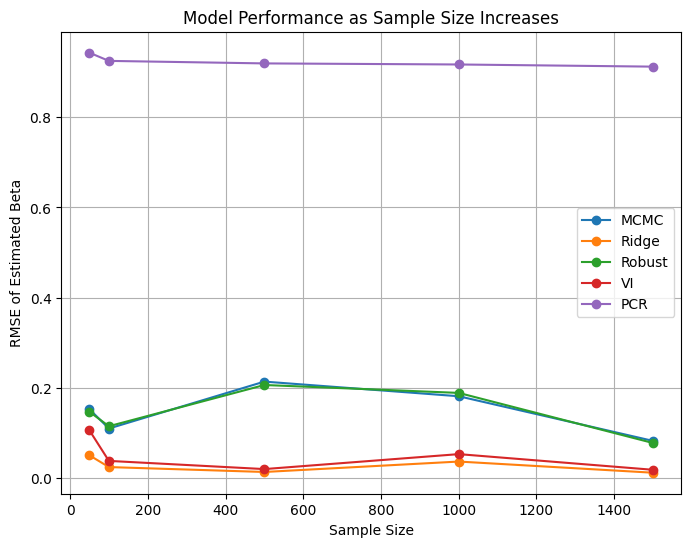

In [10]:
# Define sample sizes to test
sample_sizes = [50, 100, 500, 1000, 1500]
rmse_results = {"MCMC": [], "Ridge": [], "Robust": [], "VI": [], "PCR" : []}

for n in sample_sizes:
    print(f"Running models for sample size: {n}")
    rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi, rmse_pcr = run_models_and_evaluate(n)
    rmse_results["MCMC"].append(rmse_mcmc)
    rmse_results["Ridge"].append(rmse_ridge)
    rmse_results["Robust"].append(rmse_robust)
    rmse_results["VI"].append(rmse_vi)
    rmse_results["PCR"].append(rmse_pcr)

# Plot RMSE as a function of sample size
plt.figure(figsize=(8, 6))
for model, rmse in rmse_results.items():
    plt.plot(sample_sizes, rmse, marker='o', label=model)
plt.xlabel("Sample Size")
plt.ylabel("RMSE of Estimated Beta")
plt.title("Model Performance as Sample Size Increases")
plt.legend()
plt.grid()
plt.show()

## Changing the number of parameters

In [ ]:
# Define sample sizes to test
p_numbers = [5, 20, 30, 50, 100]
n=20
rmse_results = {"MCMC": [], "Ridge": [], "Robust": [], "VI": [], "PCR" : []}

for p in p_numbers:
    print(f"Running models for this many parameters: {p}")
    rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi, rmse_pcr = run_models_and_evaluate(p)
    rmse_results["MCMC"].append(rmse_mcmc)
    rmse_results["Ridge"].append(rmse_ridge)
    rmse_results["Robust"].append(rmse_robust)
    rmse_results["VI"].append(rmse_vi)
    rmse_results["PCR"].append(rmse_pcr)

# Plot RMSE as a function of sample size
plt.figure(figsize=(8, 6))
for model, rmse in rmse_results.items():
    plt.plot(p_numbers, rmse, marker='o', label=model)
plt.xlabel("Number of Predictors")
plt.ylabel("RMSE of Estimated Beta")
plt.title("Model Performance as Number of Predictors Increases")
plt.legend()
plt.grid()
plt.show()

Running models for this many parameters: 5


Output()

ERROR:pymc.stats.convergence:There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There were 260 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Output()

Running models for this many parameters: 20


Output()

Output()

ERROR:pymc.stats.convergence:There were 91 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Running models for this many parameters: 30


Output()

Output()

ERROR:pymc.stats.convergence:There were 515 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Running models for this many parameters: 5


Output()

Output()

ERROR:pymc.stats.convergence:There were 87 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Running models for this many parameters: 10


Output()

Output()

ERROR:pymc.stats.convergence:There were 116 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Running models for this many parameters: 20


Output()

Output()

ERROR:pymc.stats.convergence:There were 139 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Running models for this many parameters: 30


Output()

Output()

ERROR:pymc.stats.convergence:There were 351 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Output()

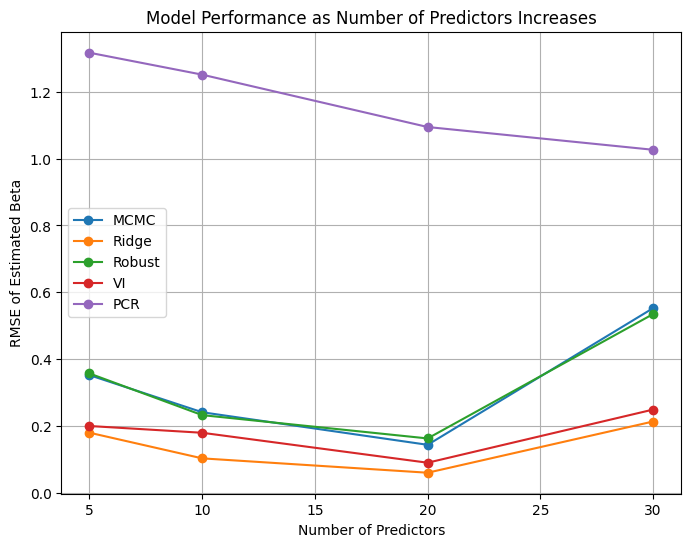

In [12]:
# Define sample sizes to test
p_numbers = [5, 20, 30, 50, 100]
n=20
rmse_results = {"MCMC": [], "Ridge": [], "Robust": [], "VI": [], "PCR" : []}

for p in p_numbers:
    print(f"Running models for this many parameters: {p}")
    rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi, rmse_pcr = run_models_and_evaluate(p)
    rmse_results["MCMC"].append(rmse_mcmc)
    rmse_results["Ridge"].append(rmse_ridge)
    rmse_results["Robust"].append(rmse_robust)
    rmse_results["VI"].append(rmse_vi)
    rmse_results["PCR"].append(rmse_pcr)

# Plot RMSE as a function of sample size
plt.figure(figsize=(8, 6))
for model, rmse in rmse_results.items():
    plt.plot(p_numbers, rmse, marker='o', label=model)
plt.xlabel("Number of Predictors")
plt.ylabel("RMSE of Estimated Beta")
plt.title("Model Performance as Number of Predictors Increases")
plt.legend()
plt.grid()
plt.show()

## Changing magnitudes

Running models with true_beta: [np.float64(1.0), 1, np.float64(1.4142135623730951), np.float64(1.681792830507429), np.float64(2.0)]


Output()

ERROR:pymc.stats.convergence:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There were 88 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Running models with true_beta: [np.float64(1.0), 2, np.float64(1.4142135623730951), np.float64(1.681792830507429), np.float64(2.0)]


Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Running models with true_beta: [np.float64(1.0), 4, np.float64(1.4142135623730951), np.float64(1.681792830507429), np.float64(2.0)]


Output()

Output()

ERROR:pymc.stats.convergence:There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Output()

Running models with true_beta: [np.float64(1.0), 8, np.float64(1.4142135623730951), np.float64(1.681792830507429), np.float64(2.0)]


Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There were 204 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Output()

Running models with true_beta: [np.float64(1.0), 16, np.float64(1.4142135623730951), np.float64(1.681792830507429), np.float64(2.0)]


Output()

Output()

ERROR:pymc.stats.convergence:There were 45 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

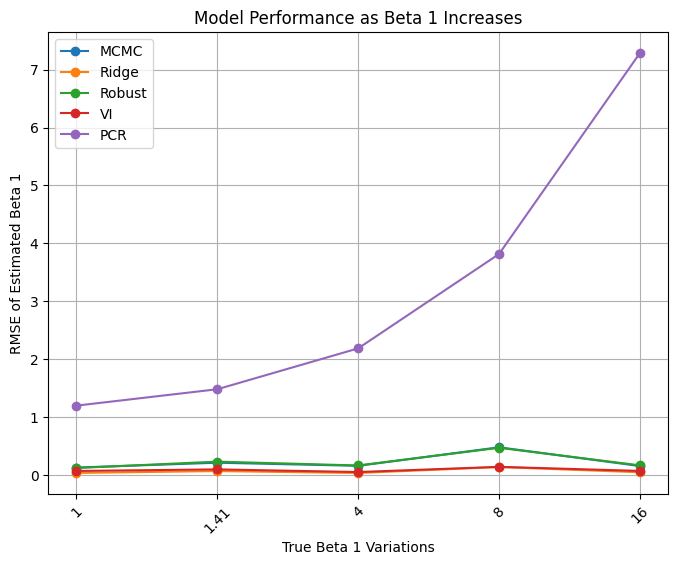

In [14]:
p=5
# Fixed 5-element true_beta array
true_beta = np.logspace(0, 1, p, base=2)

# Define different values where only one coefficient increases at a time
beta_variations = [ [true_beta[0], 2**i, *true_beta[2:]] for i in range(5)]


n = 20
rmse_results = {"MCMC": [], "Ridge": [], "Robust": [], "VI": [], "PCR": []}

for true_beta in beta_variations:
    print(f"Running models with true_beta: {true_beta}")
    rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi, rmse_pcr = run_models_and_evaluate(n = n, true_beta = true_beta)
    rmse_results["MCMC"].append(rmse_mcmc)
    rmse_results["Ridge"].append(rmse_ridge)
    rmse_results["Robust"].append(rmse_robust)
    rmse_results["VI"].append(rmse_vi)
    rmse_results["PCR"].append(rmse_pcr)

# Plot RMSE as a function of increasing individual beta values
plt.figure(figsize=(8, 6))
beta_labels = [
    "1", "1.41", "4", "8", "16"
]
for model, rmse in rmse_results.items():
    plt.plot(beta_labels, rmse, marker='o', label=model)
plt.xlabel("True Beta 1 Variations")
plt.ylabel("RMSE of Estimated Beta 1")
plt.title("Model Performance as Beta 1 Increases")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


Running models with true_beta: [1, np.float64(1.189207115002721), np.float64(1.4142135623730951), np.float64(1.681792830507429), np.float64(2.0)]


Output()

Output()

ERROR:pymc.stats.convergence:There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Output()

Running models with true_beta: [2, np.float64(1.189207115002721), np.float64(1.4142135623730951), np.float64(1.681792830507429), np.float64(2.0)]


Output()

Output()

ERROR:pymc.stats.convergence:There were 17 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Running models with true_beta: [4, np.float64(1.189207115002721), np.float64(1.4142135623730951), np.float64(1.681792830507429), np.float64(2.0)]


Output()

Output()

ERROR:pymc.stats.convergence:There were 26 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Running models with true_beta: [8, np.float64(1.189207115002721), np.float64(1.4142135623730951), np.float64(1.681792830507429), np.float64(2.0)]


Output()

Output()

ERROR:pymc.stats.convergence:There were 57 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Running models with true_beta: [16, np.float64(1.189207115002721), np.float64(1.4142135623730951), np.float64(1.681792830507429), np.float64(2.0)]


Output()

Output()

ERROR:pymc.stats.convergence:There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

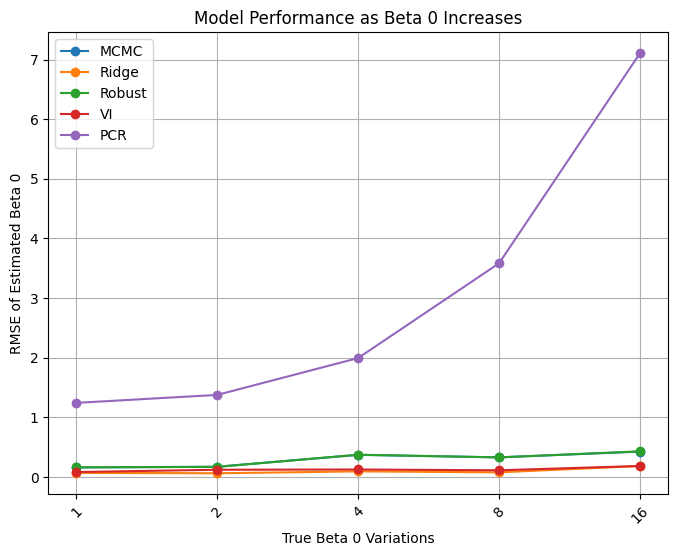

In [16]:
# Define different values where only one coefficient increases at a time
p=5
# Fixed 5-element true_beta array
true_beta = np.logspace(0, 1, p, base=2)

beta_variations = [[2**i, *true_beta[1:]] for i in range(5)]


n = 20
rmse_results = {"MCMC": [], "Ridge": [], "Robust": [], "VI": [], "PCR": []}

for true_beta in beta_variations:
    print(f"Running models with true_beta: {true_beta}")
    rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi, rmse_pcr = run_models_and_evaluate(n = n, true_beta = true_beta)
    rmse_results["MCMC"].append(rmse_mcmc)
    rmse_results["Ridge"].append(rmse_ridge)
    rmse_results["Robust"].append(rmse_robust)
    rmse_results["VI"].append(rmse_vi)
    rmse_results["PCR"].append(rmse_pcr)

# Plot RMSE as a function of increasing individual beta values
plt.figure(figsize=(8, 6))
beta_labels = [
    "1", "2", "4", "8", "16"
]
for model, rmse in rmse_results.items():
    plt.plot(beta_labels, rmse, marker='o', label=model)
plt.xlabel("True Beta 0 Variations")
plt.ylabel("RMSE of Estimated Beta 0")
plt.title("Model Performance as Beta 0 Increases")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


## Applied to datasets

Running Bayesian Linear Regression...


Output()

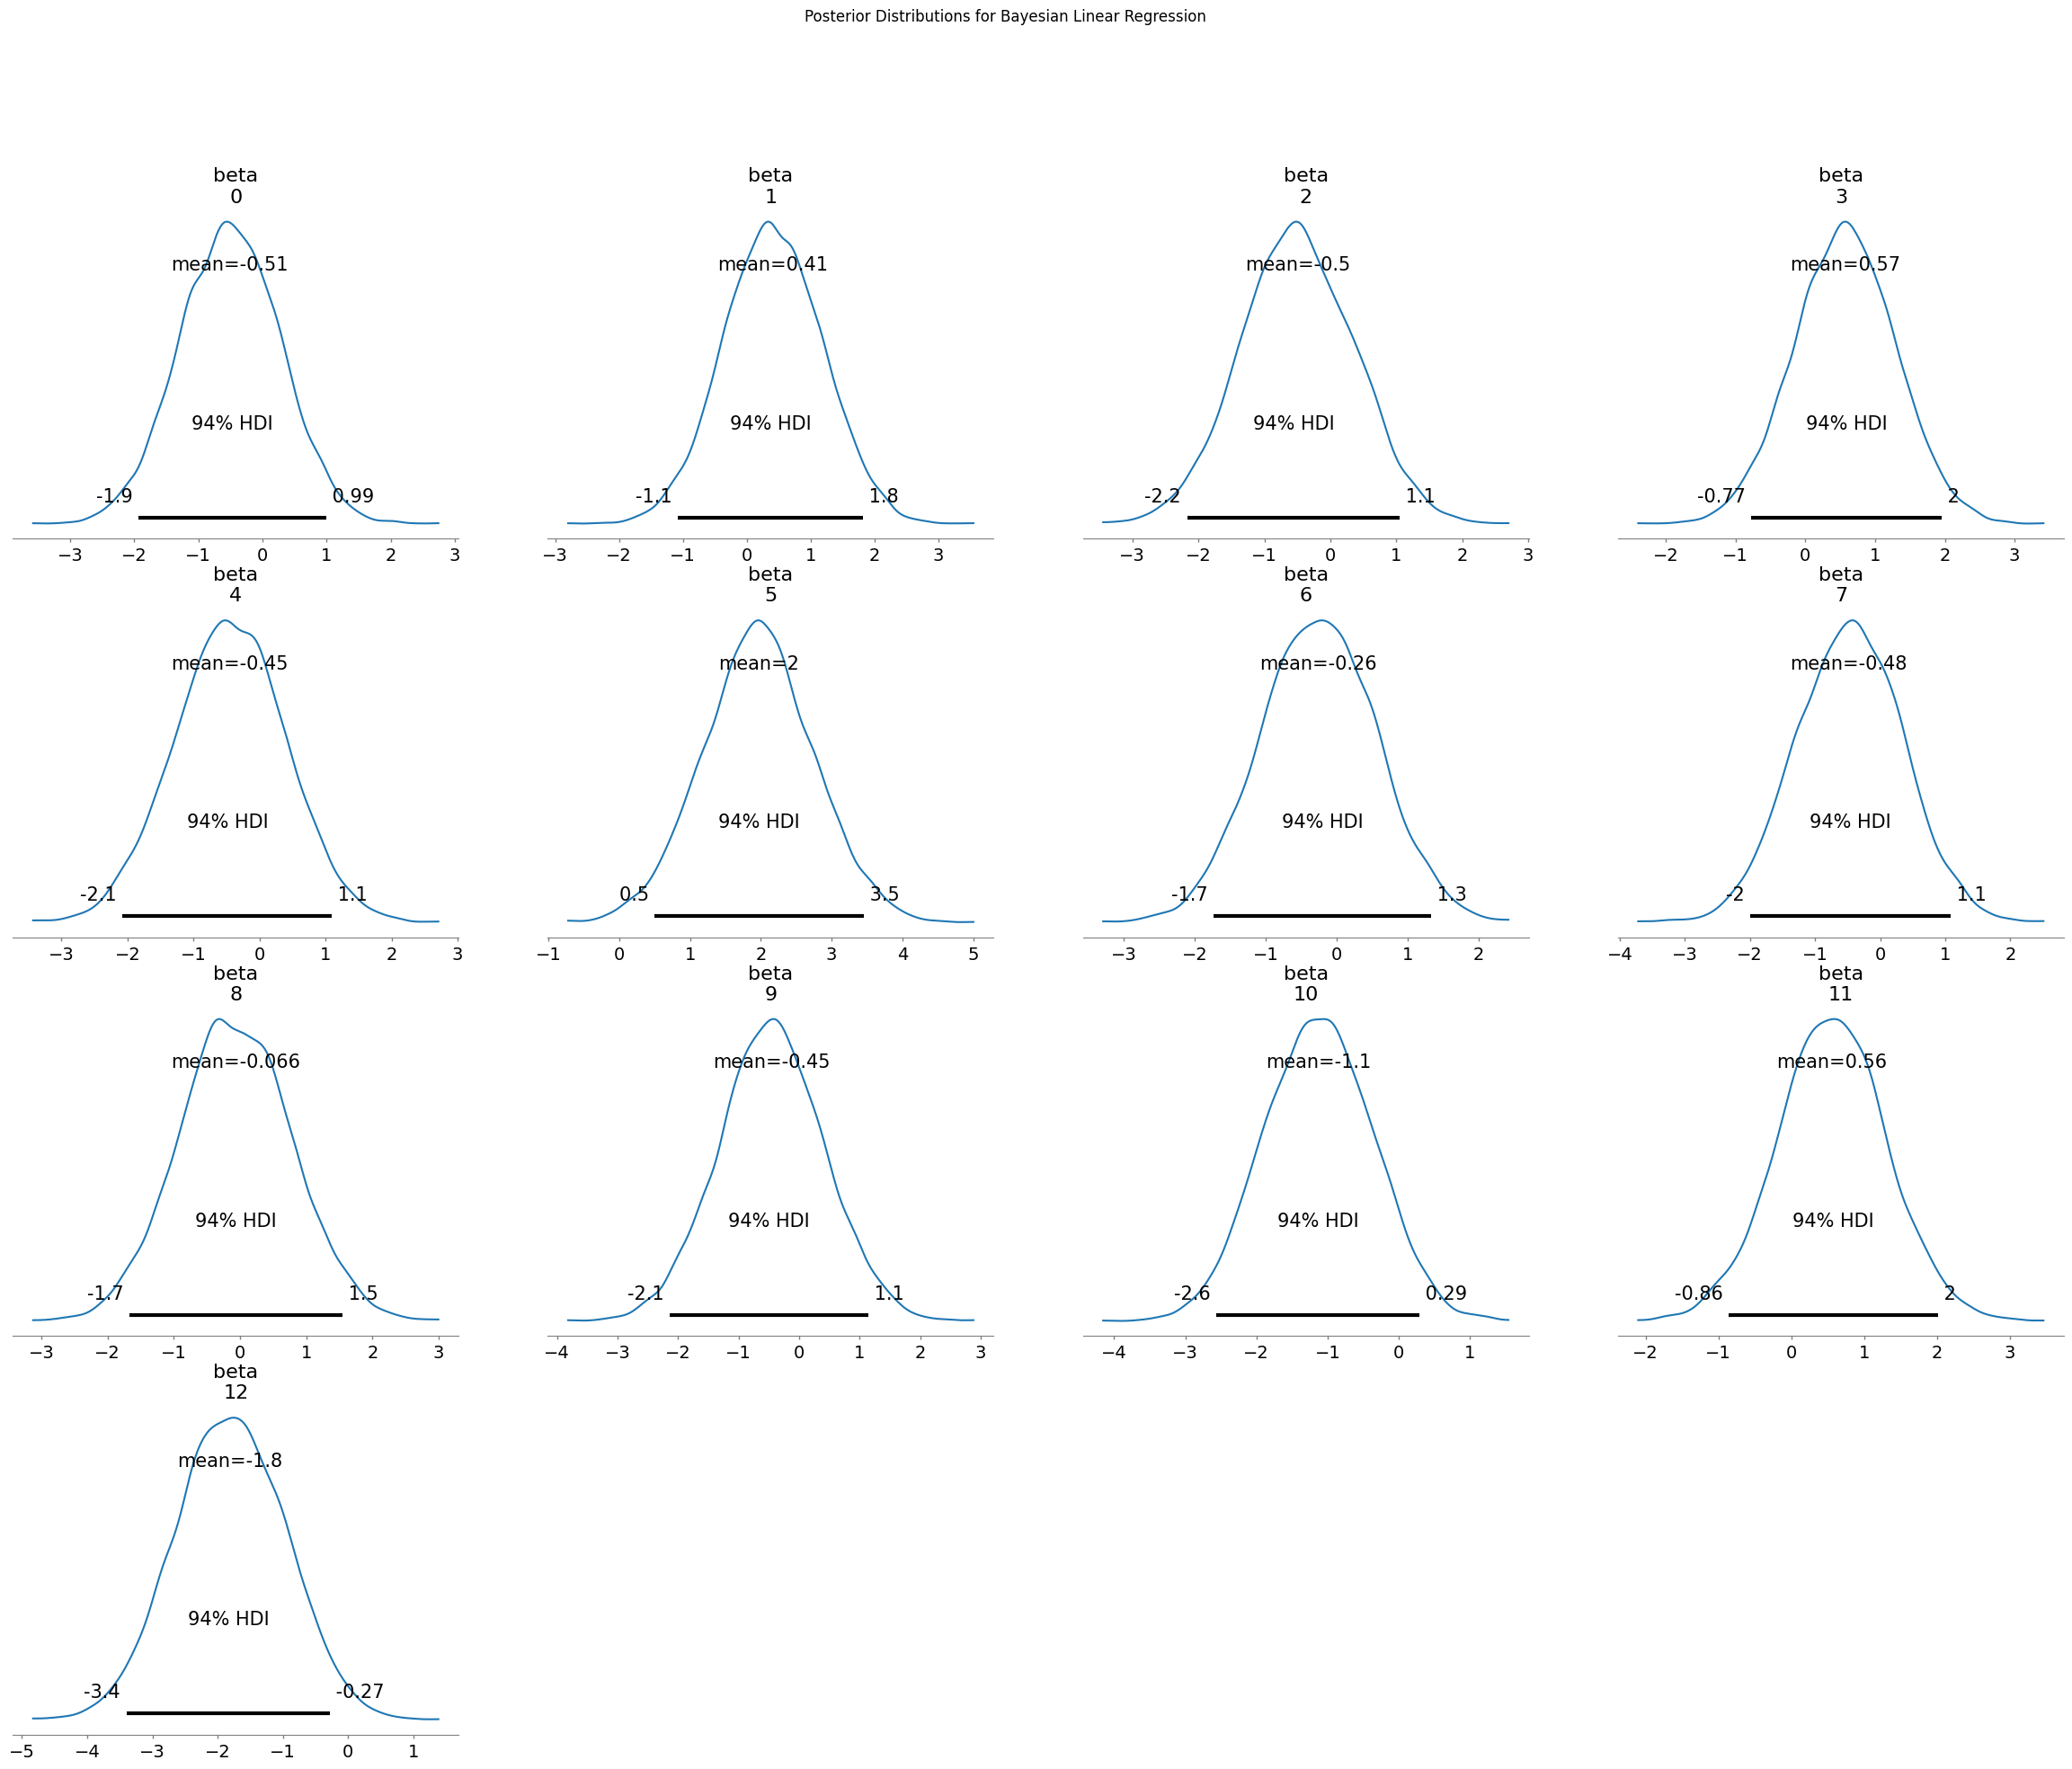

Running Bayesian Ridge Regression...


Output()

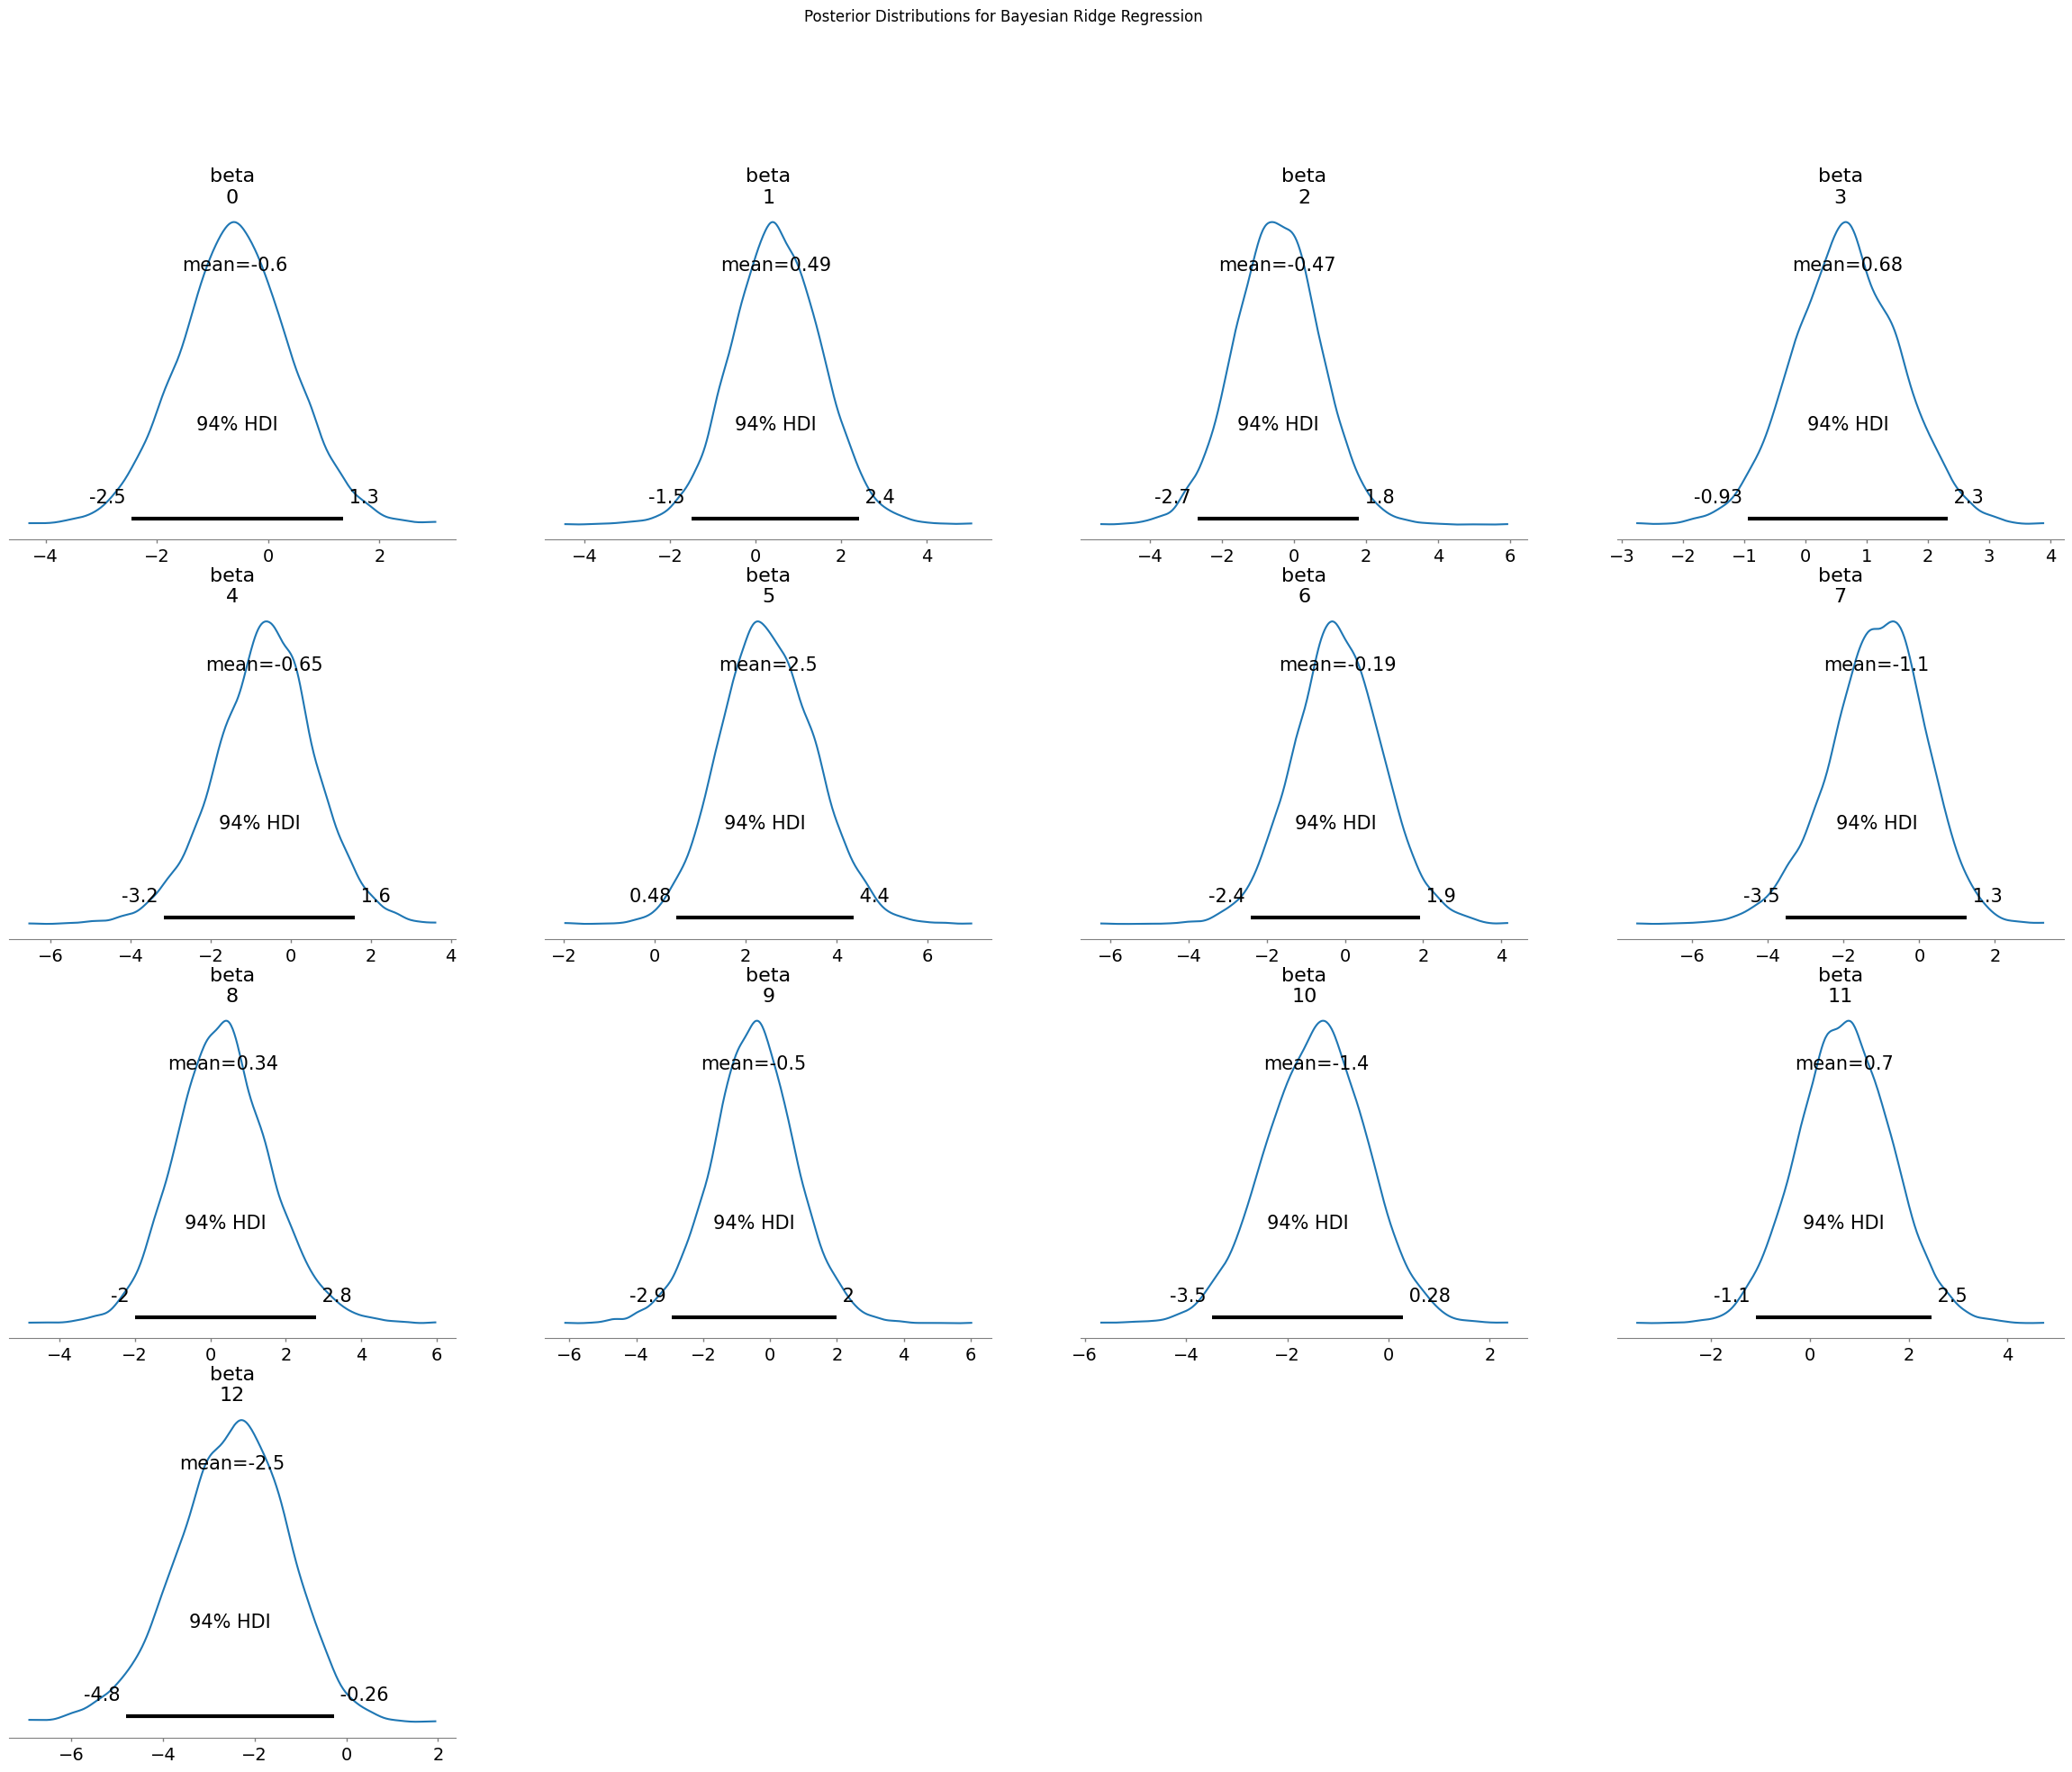

Running Bayesian Robust Regression...


Output()

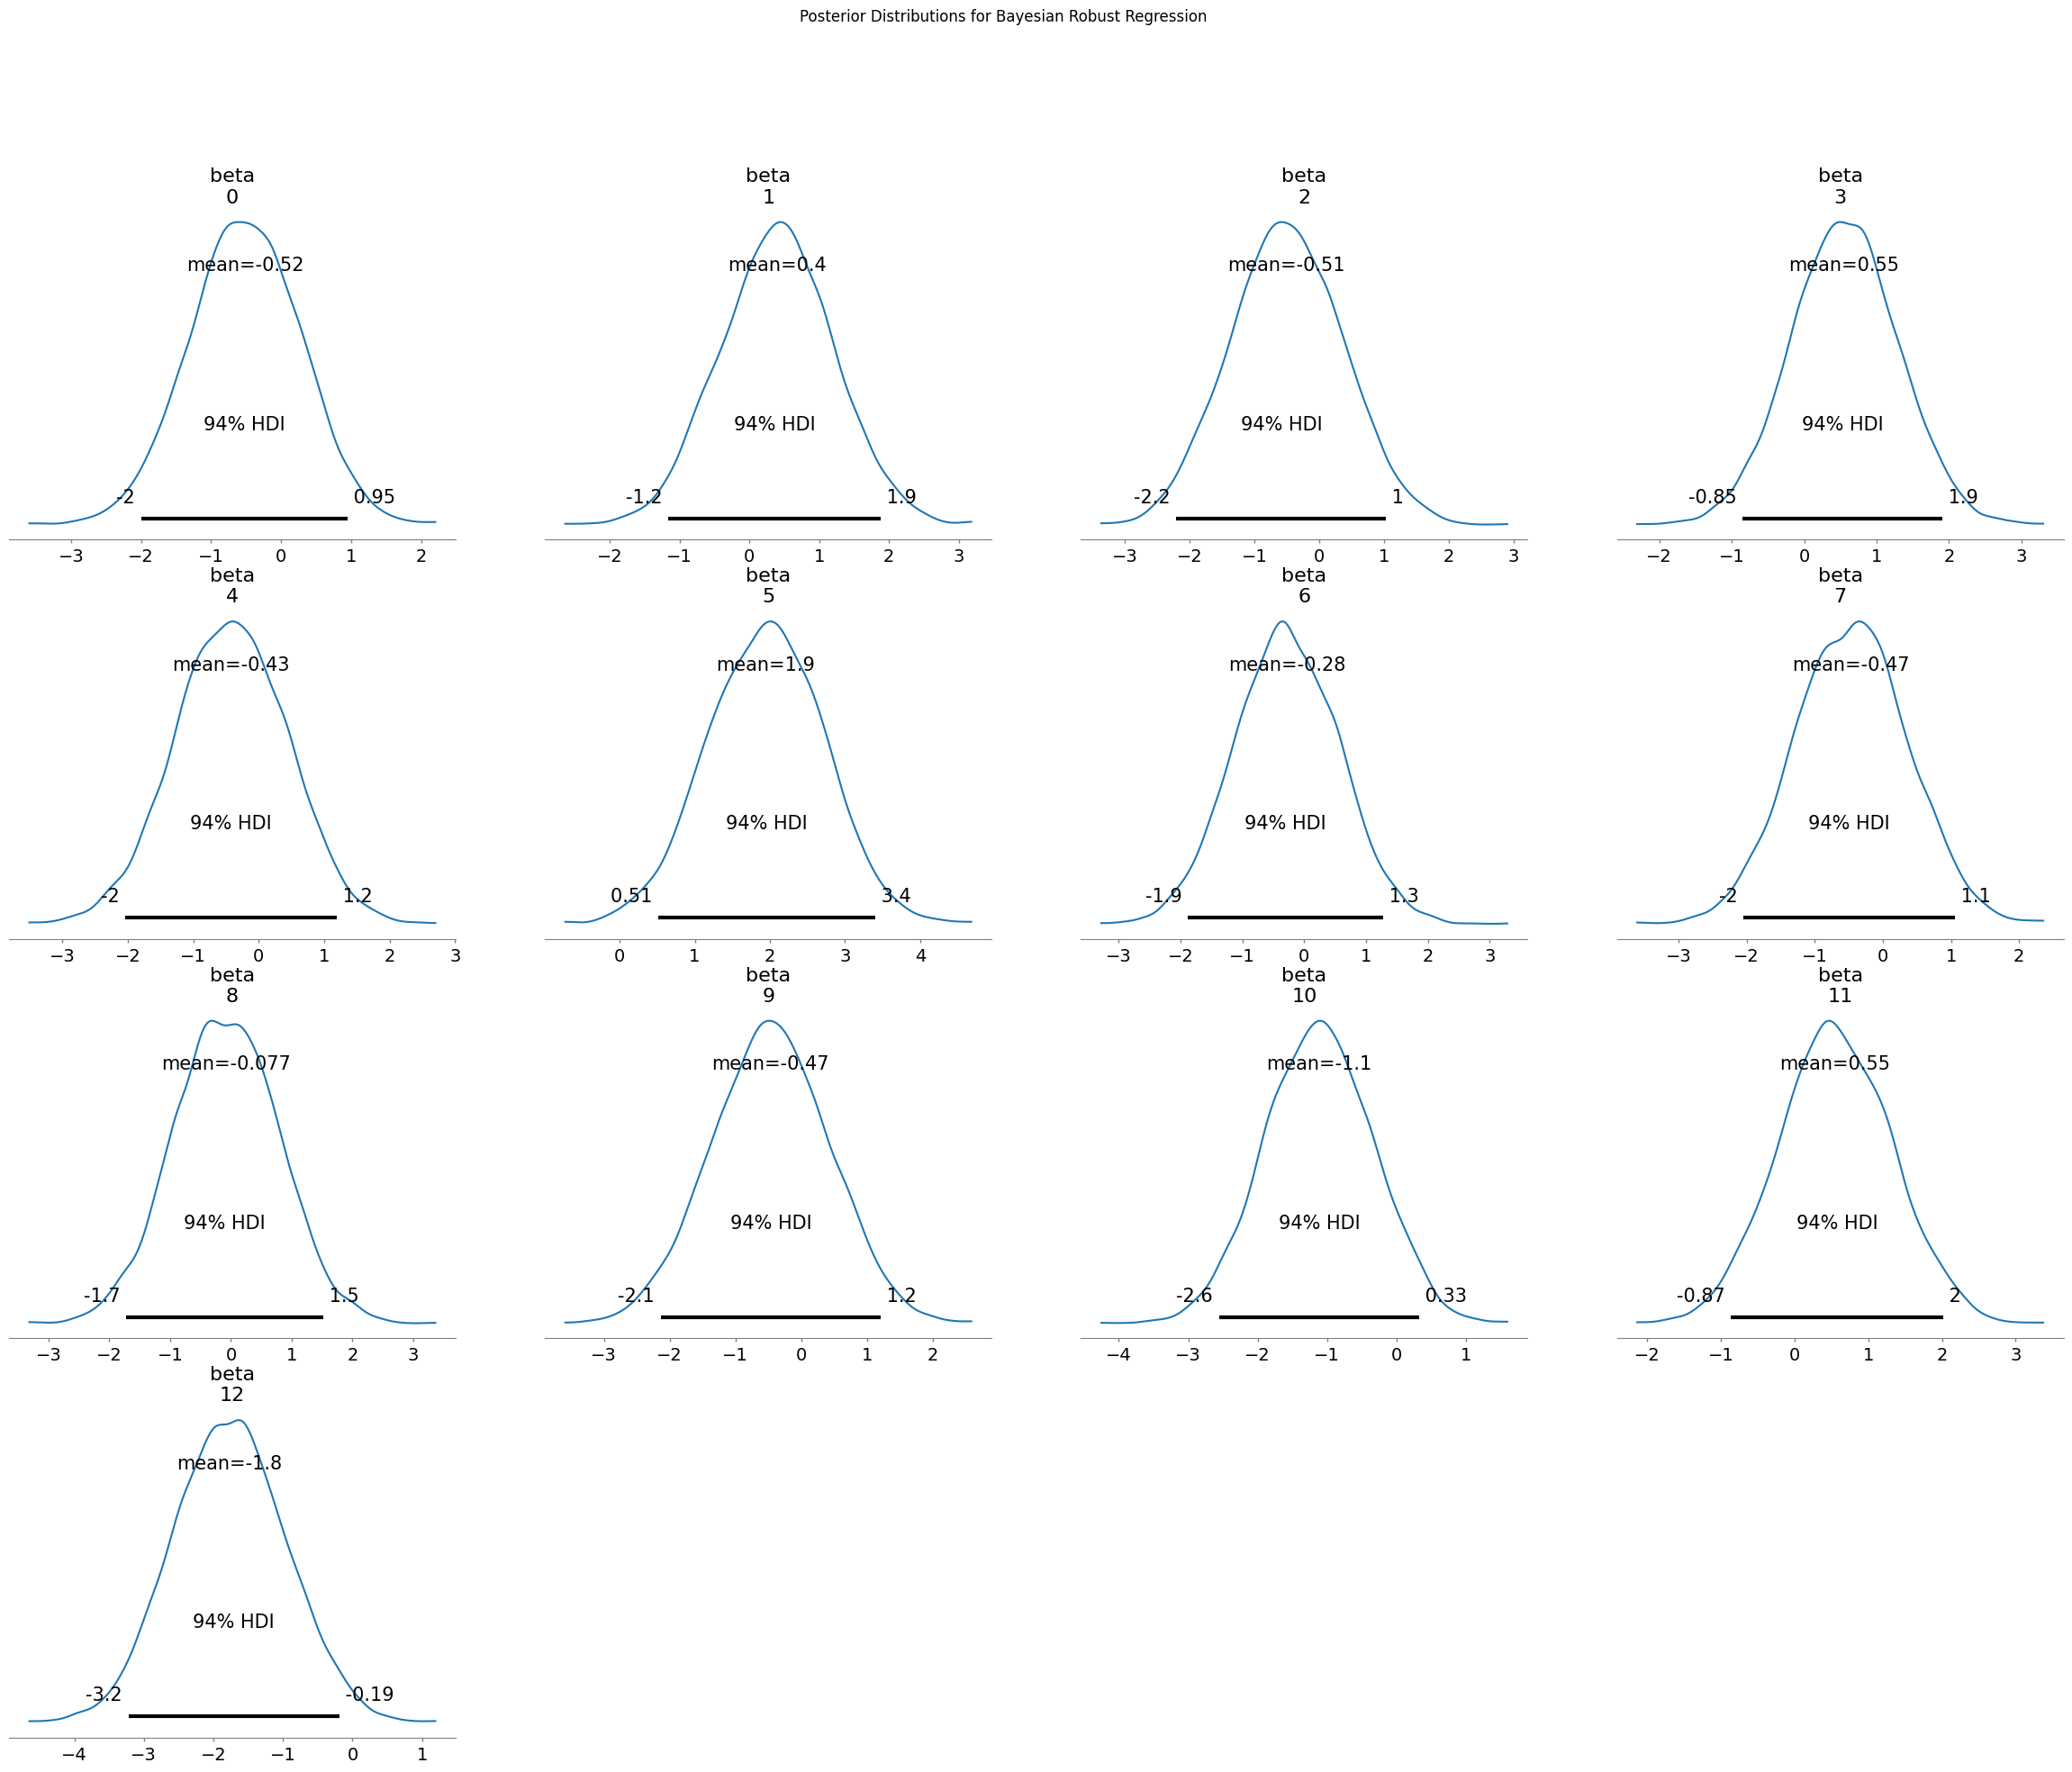

Running Bayesian Regression VI...


Output()

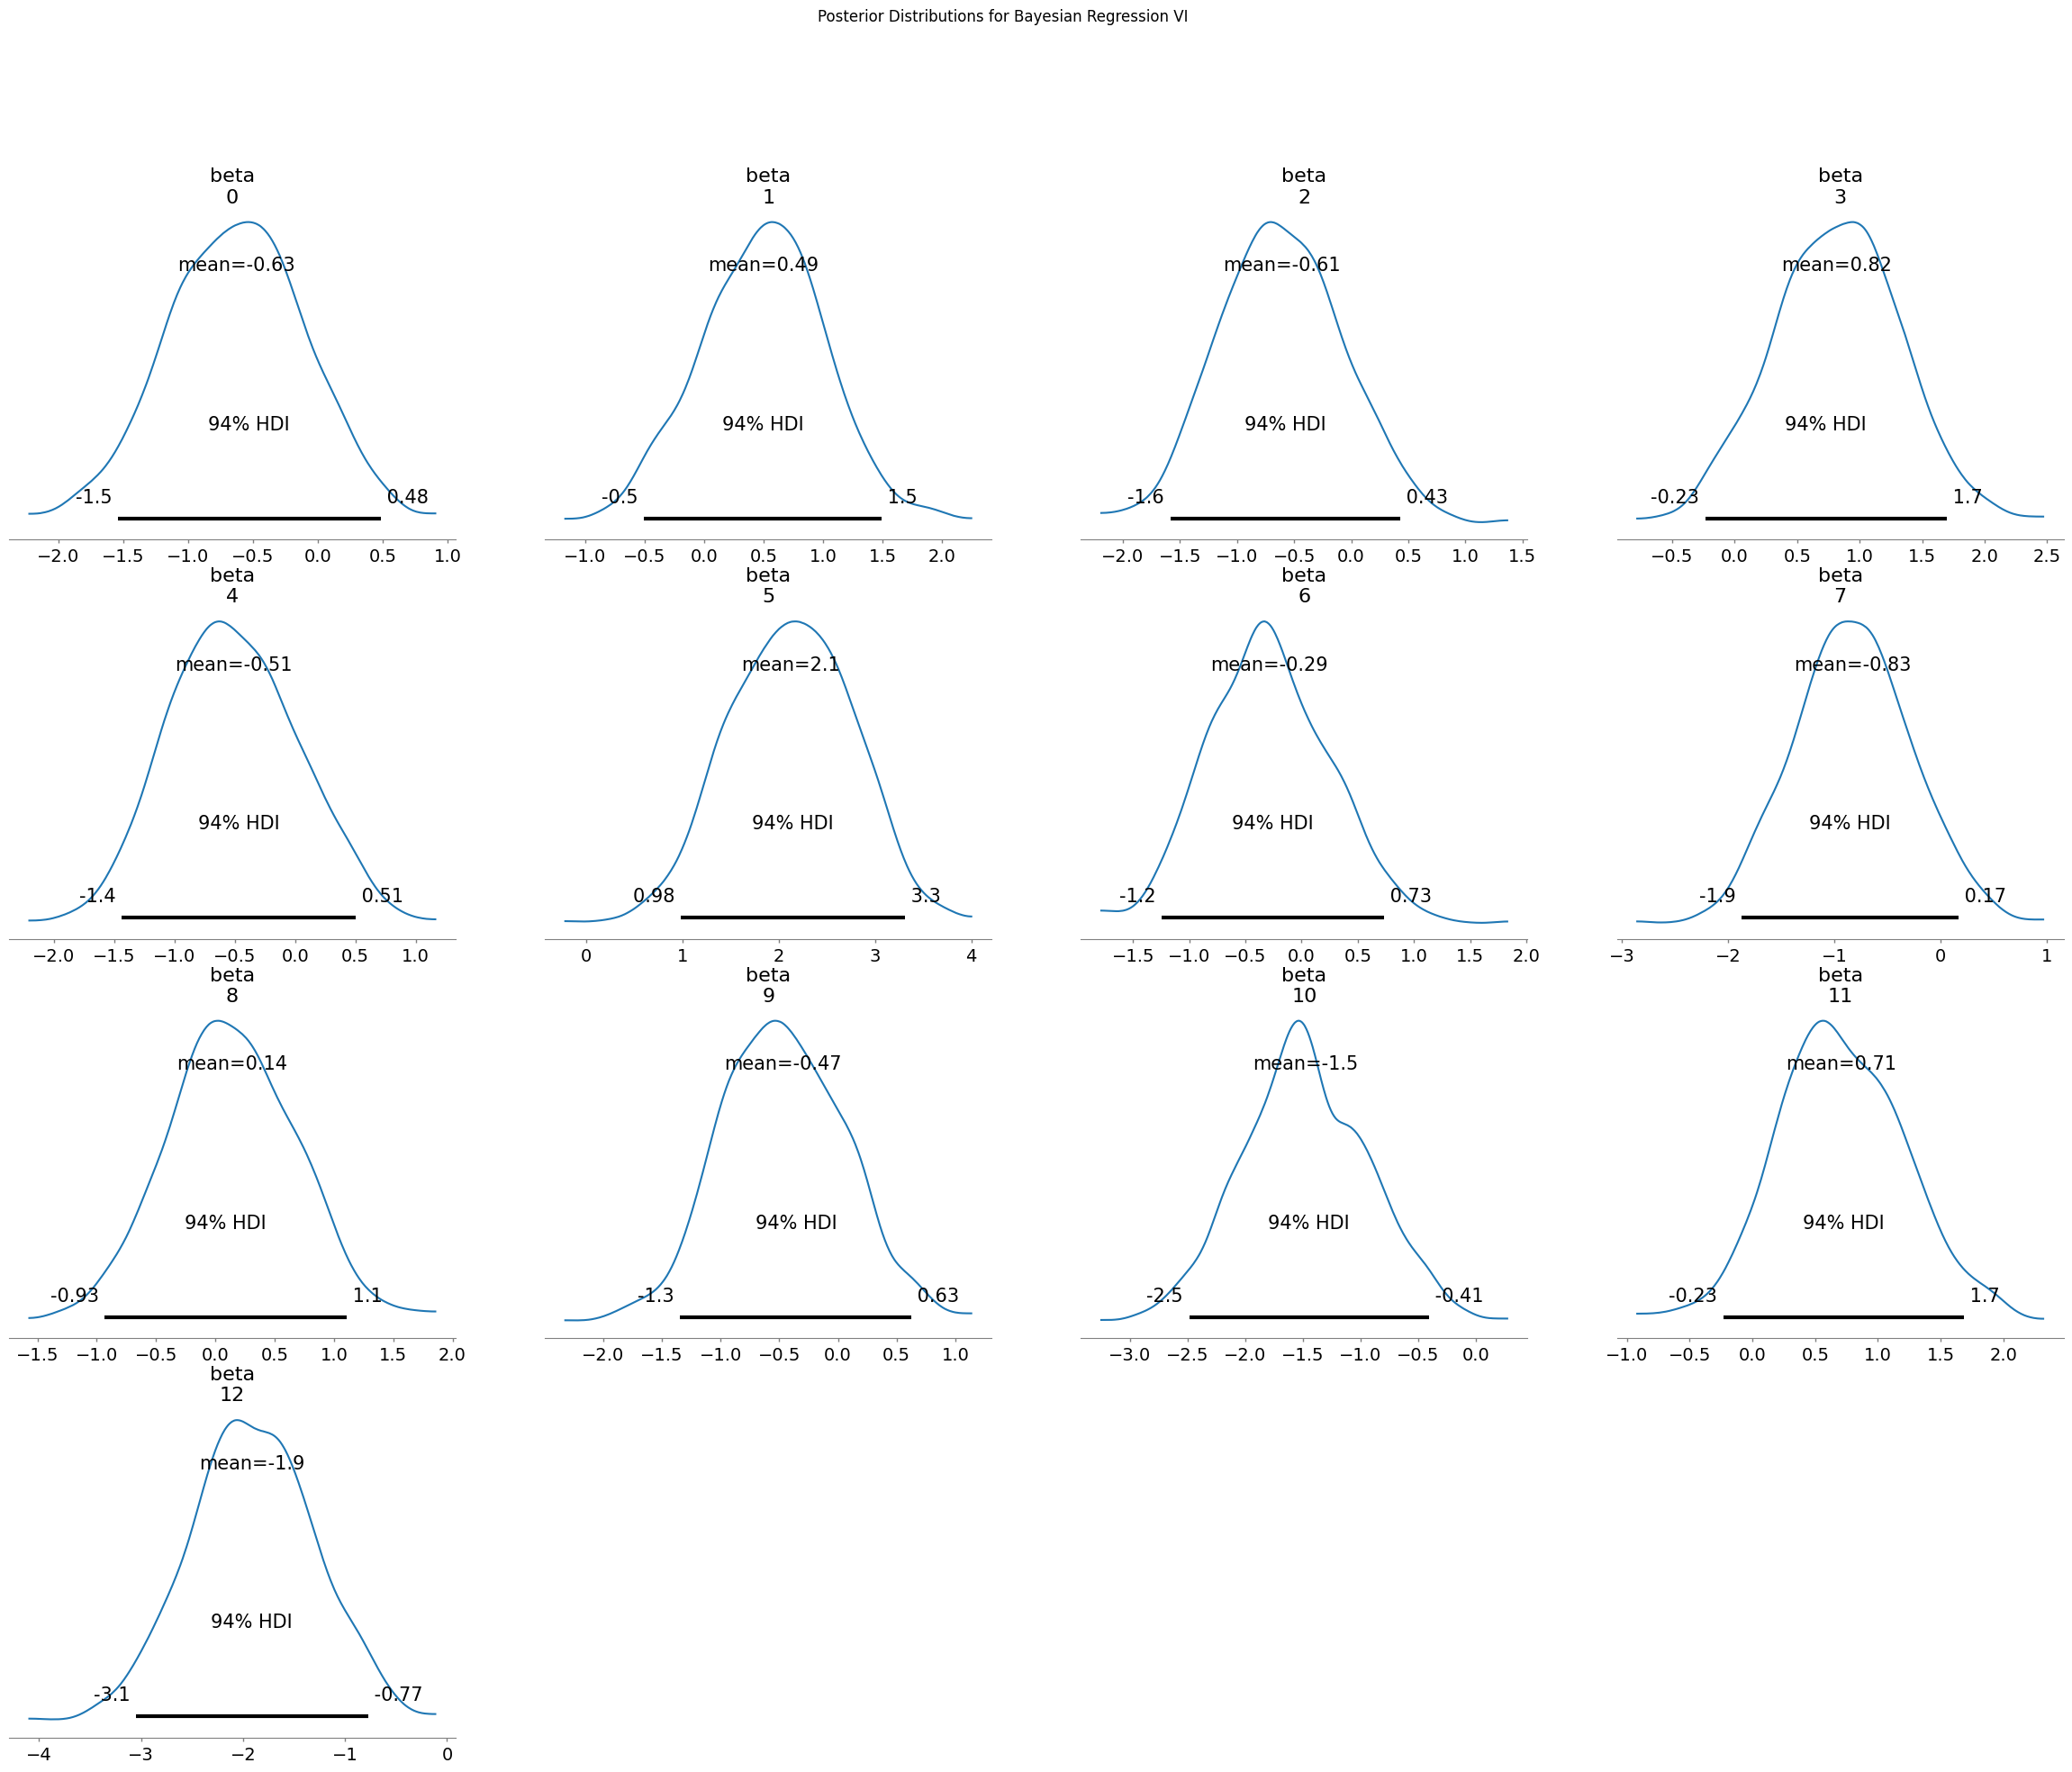

Running Bayesian PCR...


Output()

ValueError: shapes (506,13) and (2,) not aligned: 13 (dim 1) != 2 (dim 0)

In [42]:
housing = pd.read_csv("https://raw.githubusercontent.com/javmencia/STA410/refs/heads/main/housing.csv", header = None, sep = r"\s+")
housing.columns = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"]
housing.head()

# Define X (predictors) and y (target variable)
X = housing.drop(columns=["MEDV"]).values
y = housing["MEDV"].values

# Normalize X
X = (X - X.mean(axis=0)) / X.std(axis=0)

def run_and_plot_models(X, y, n_components=2):
    models = [bayesian_regression_mcmc, bayesian_ridge_regression, bayesian_robust_regression, bayesian_regression_vi, bayesian_pcr]
    model_names = ["Bayesian Linear Regression", "Bayesian Ridge Regression", "Bayesian Robust Regression", "Bayesian Regression VI", "Bayesian PCR"]

    results = []

    for model, name in zip(models, model_names):
        print(f"Running {name}...")

        # Fit the model
        if name == "Bayesian PCR":
            mod, trace = model(X, y, n_components=n_components)
        else:
            mod, trace = model(X, y)

        # Extract posterior mean for beta coefficients
        beta_means = trace.posterior["beta"].mean(dim=("chain", "draw")).values.flatten()

        # Generate predictions
        y_pred = np.dot(X, beta_means)

        # Compute performance metric (Mean Squared Error)
        mse = np.mean((y - y_pred) ** 2)

        # Store results
        results.append([name] + list(beta_means) + [mse])

        # Plot posterior distributions
        pm.plot_posterior(trace, var_names=["beta"])
        plt.suptitle(f"Posterior Distributions for {name}")
        plt.show()

    # Create DataFrame to display results
    coef_names = [f"Beta_{i+1}" for i in range(X.shape[1])]
    columns = ["Model"] + coef_names + ["MSE"]
    results_df = pd.DataFrame(results, columns=columns)

    print("\nModel Performance Summary:")
    print(results_df)

    return results_df


run_and_plot_models(X, y, n_components=2)

Running Bayesian Linear Regression...


Output()

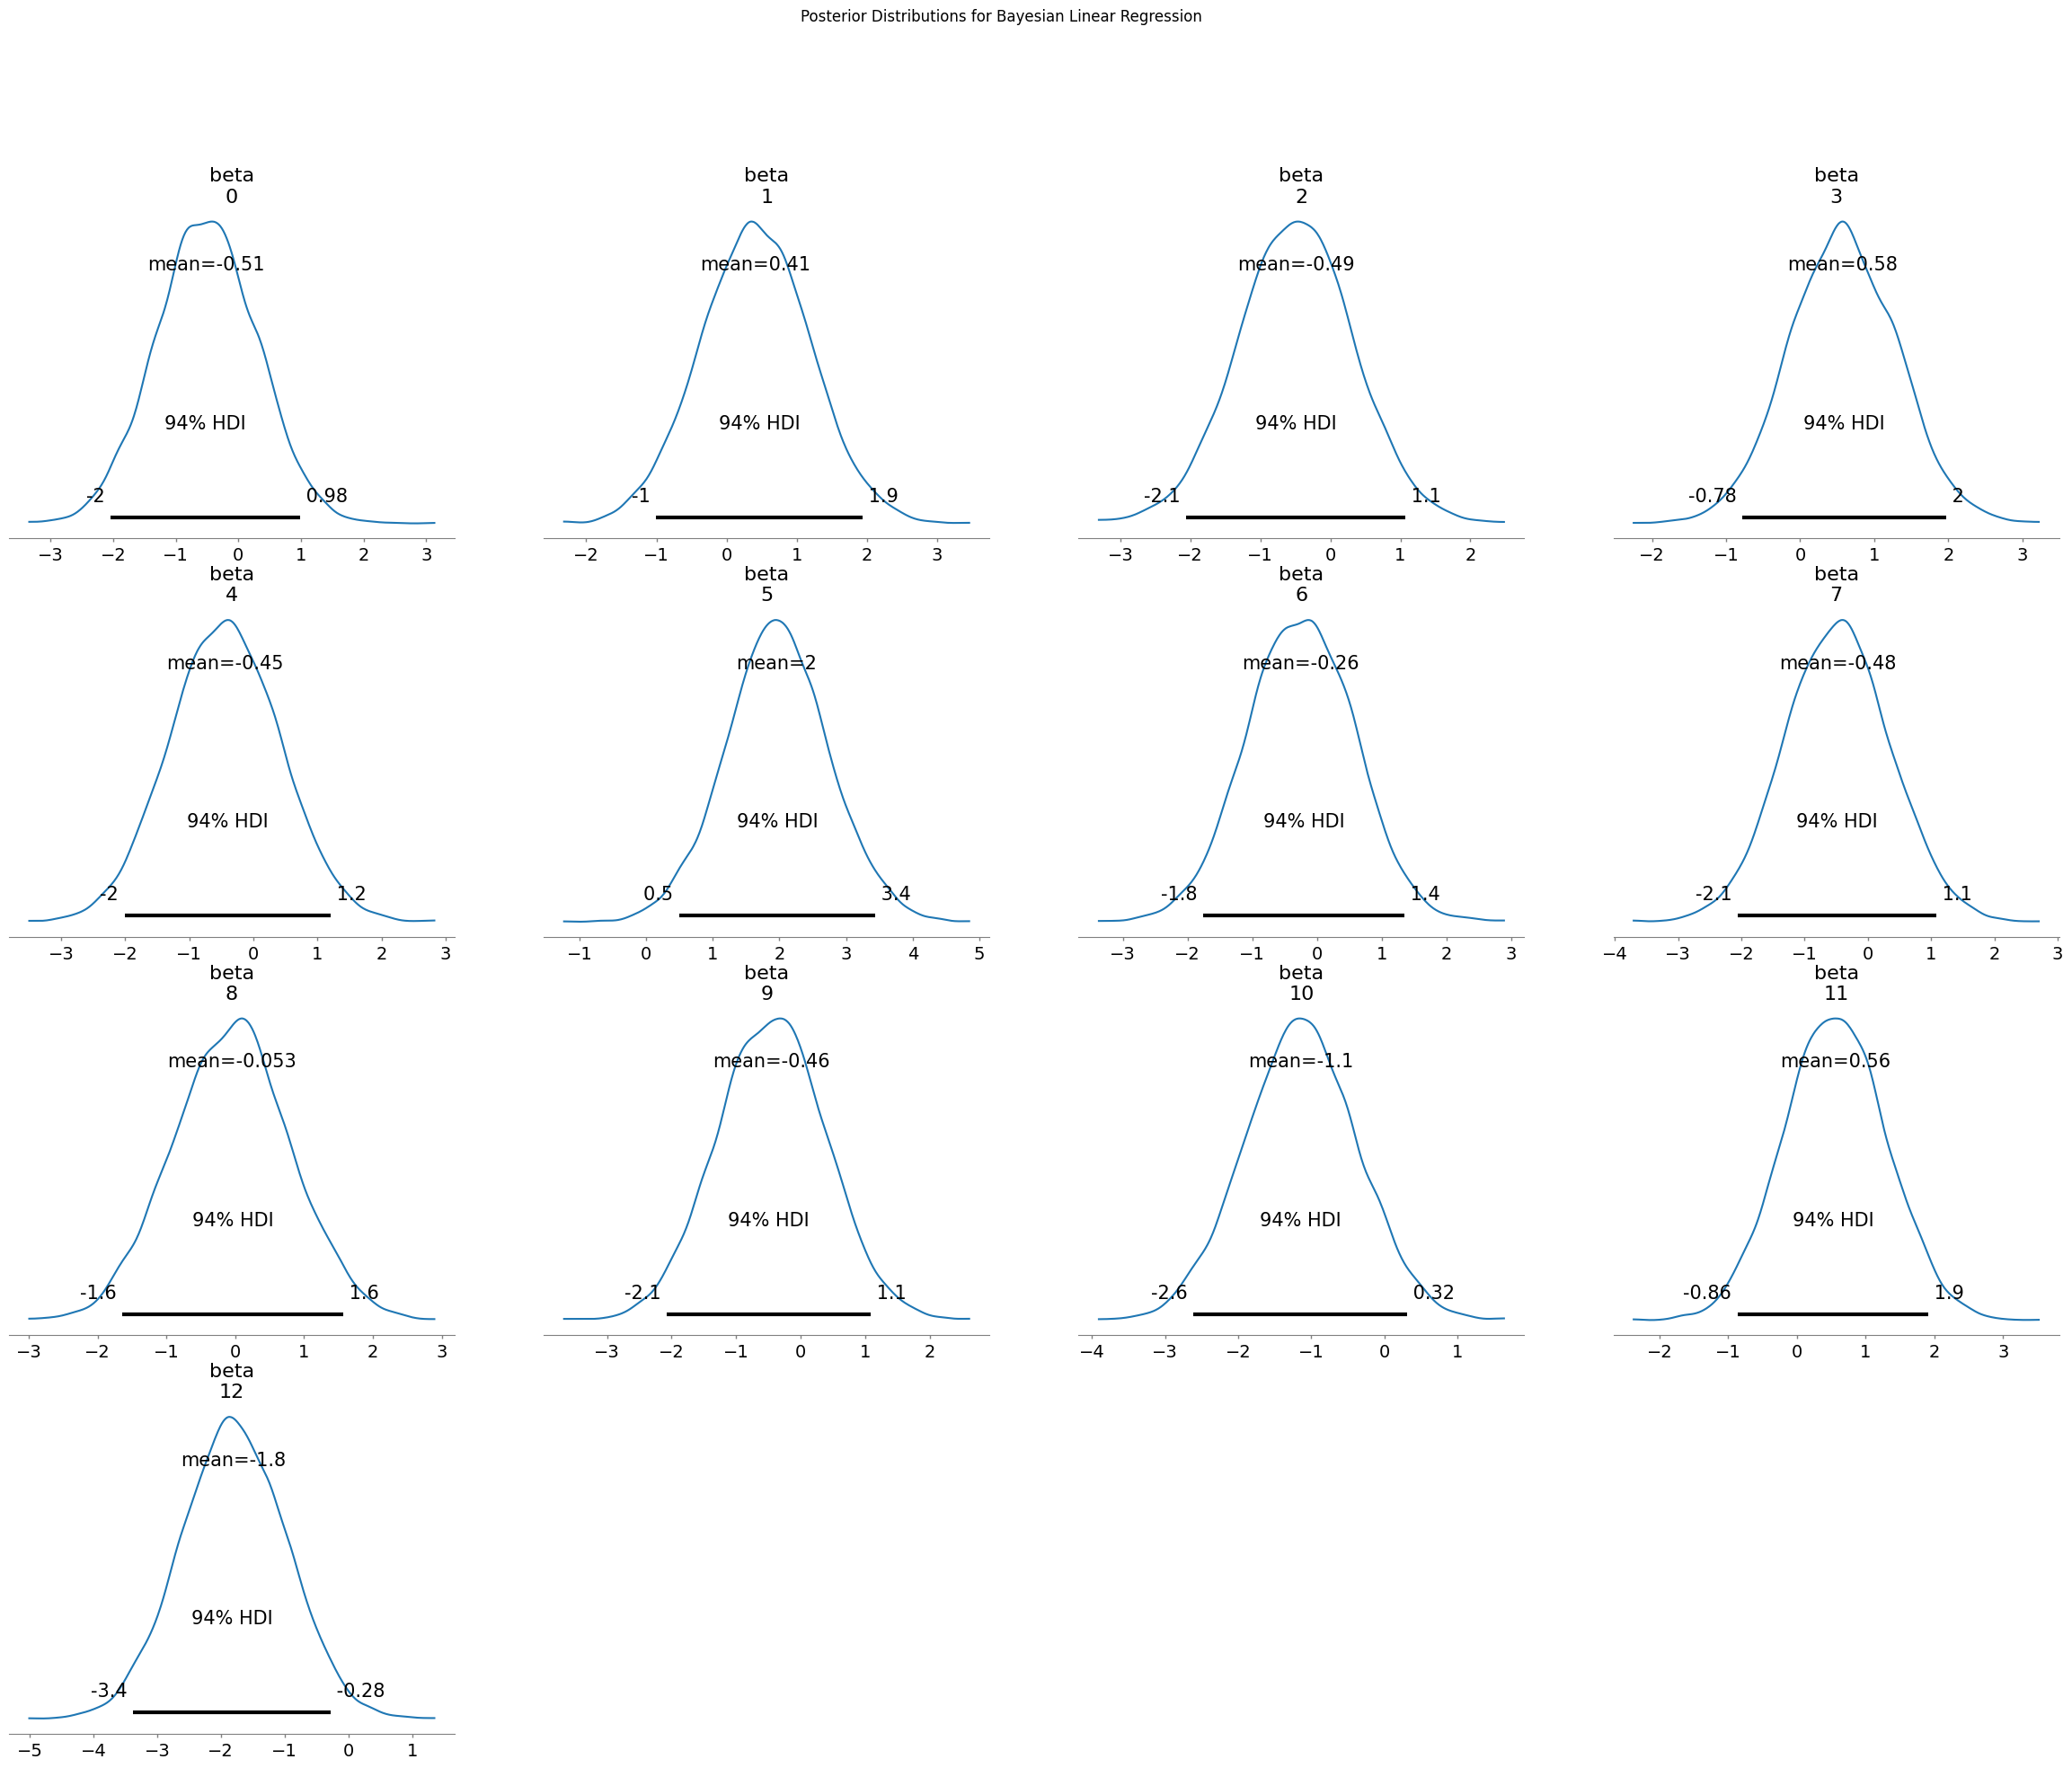

Running Bayesian Ridge Regression...


Output()

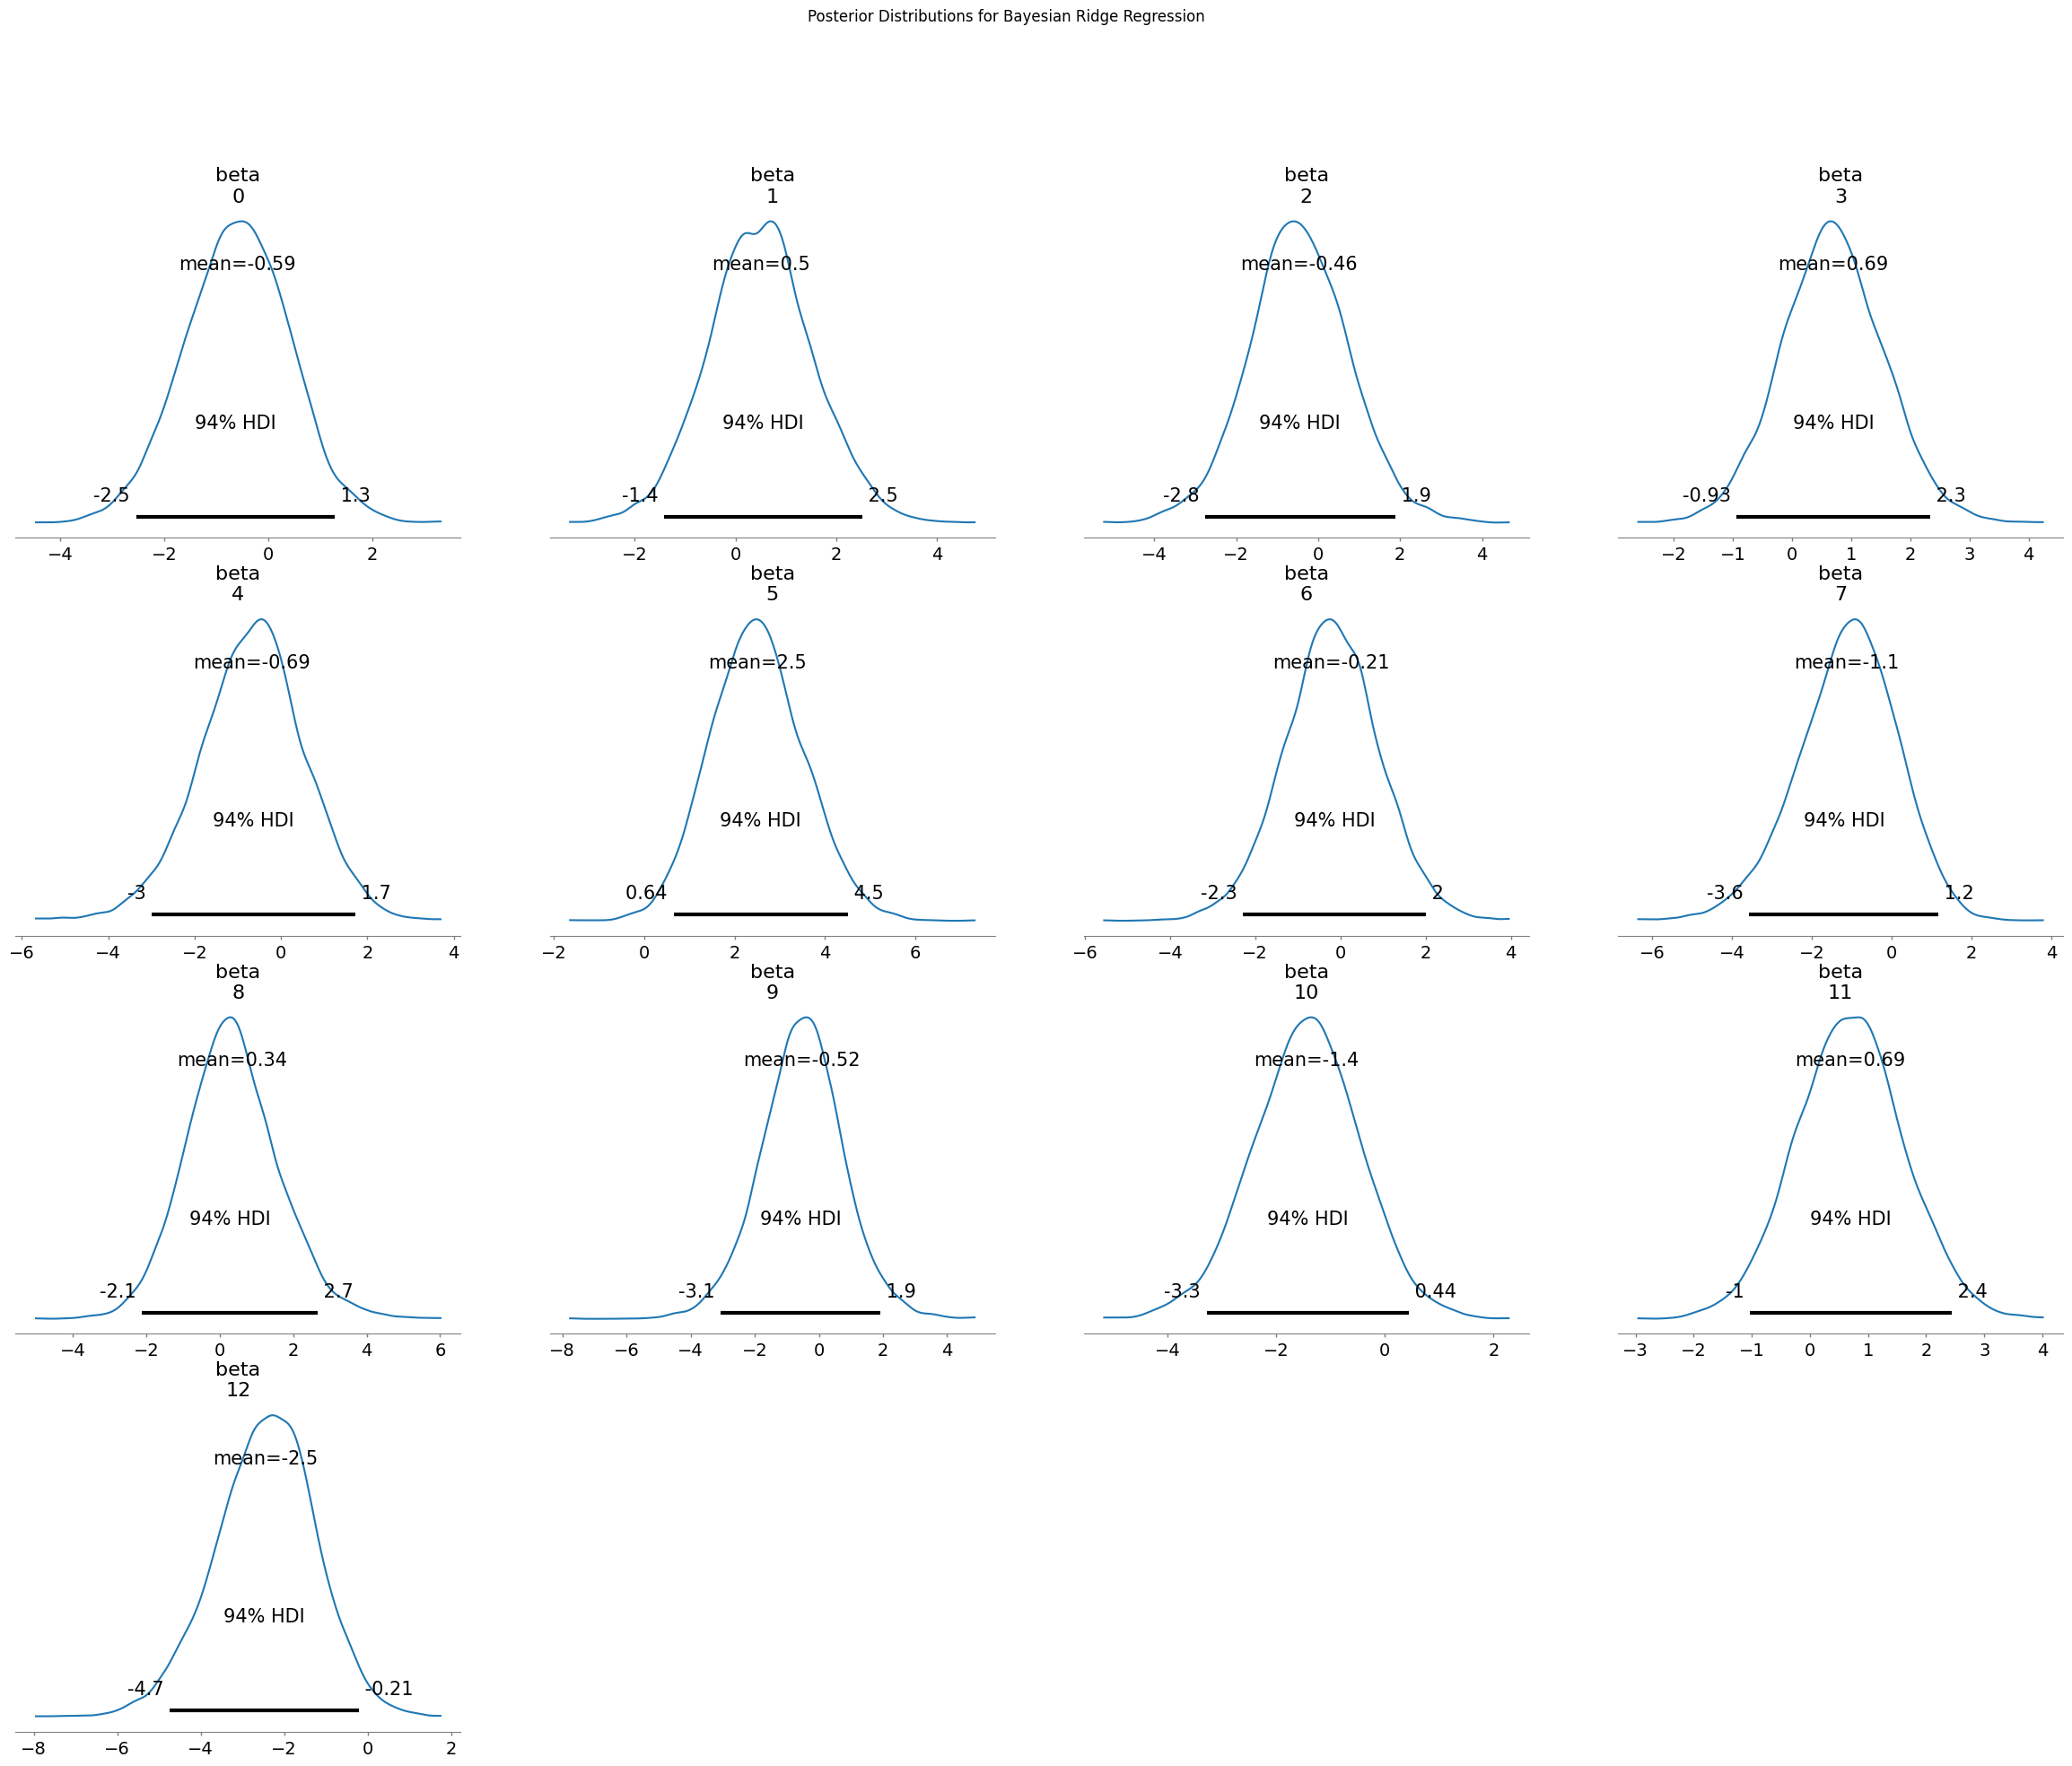

Running Bayesian Robust Regression...


Output()

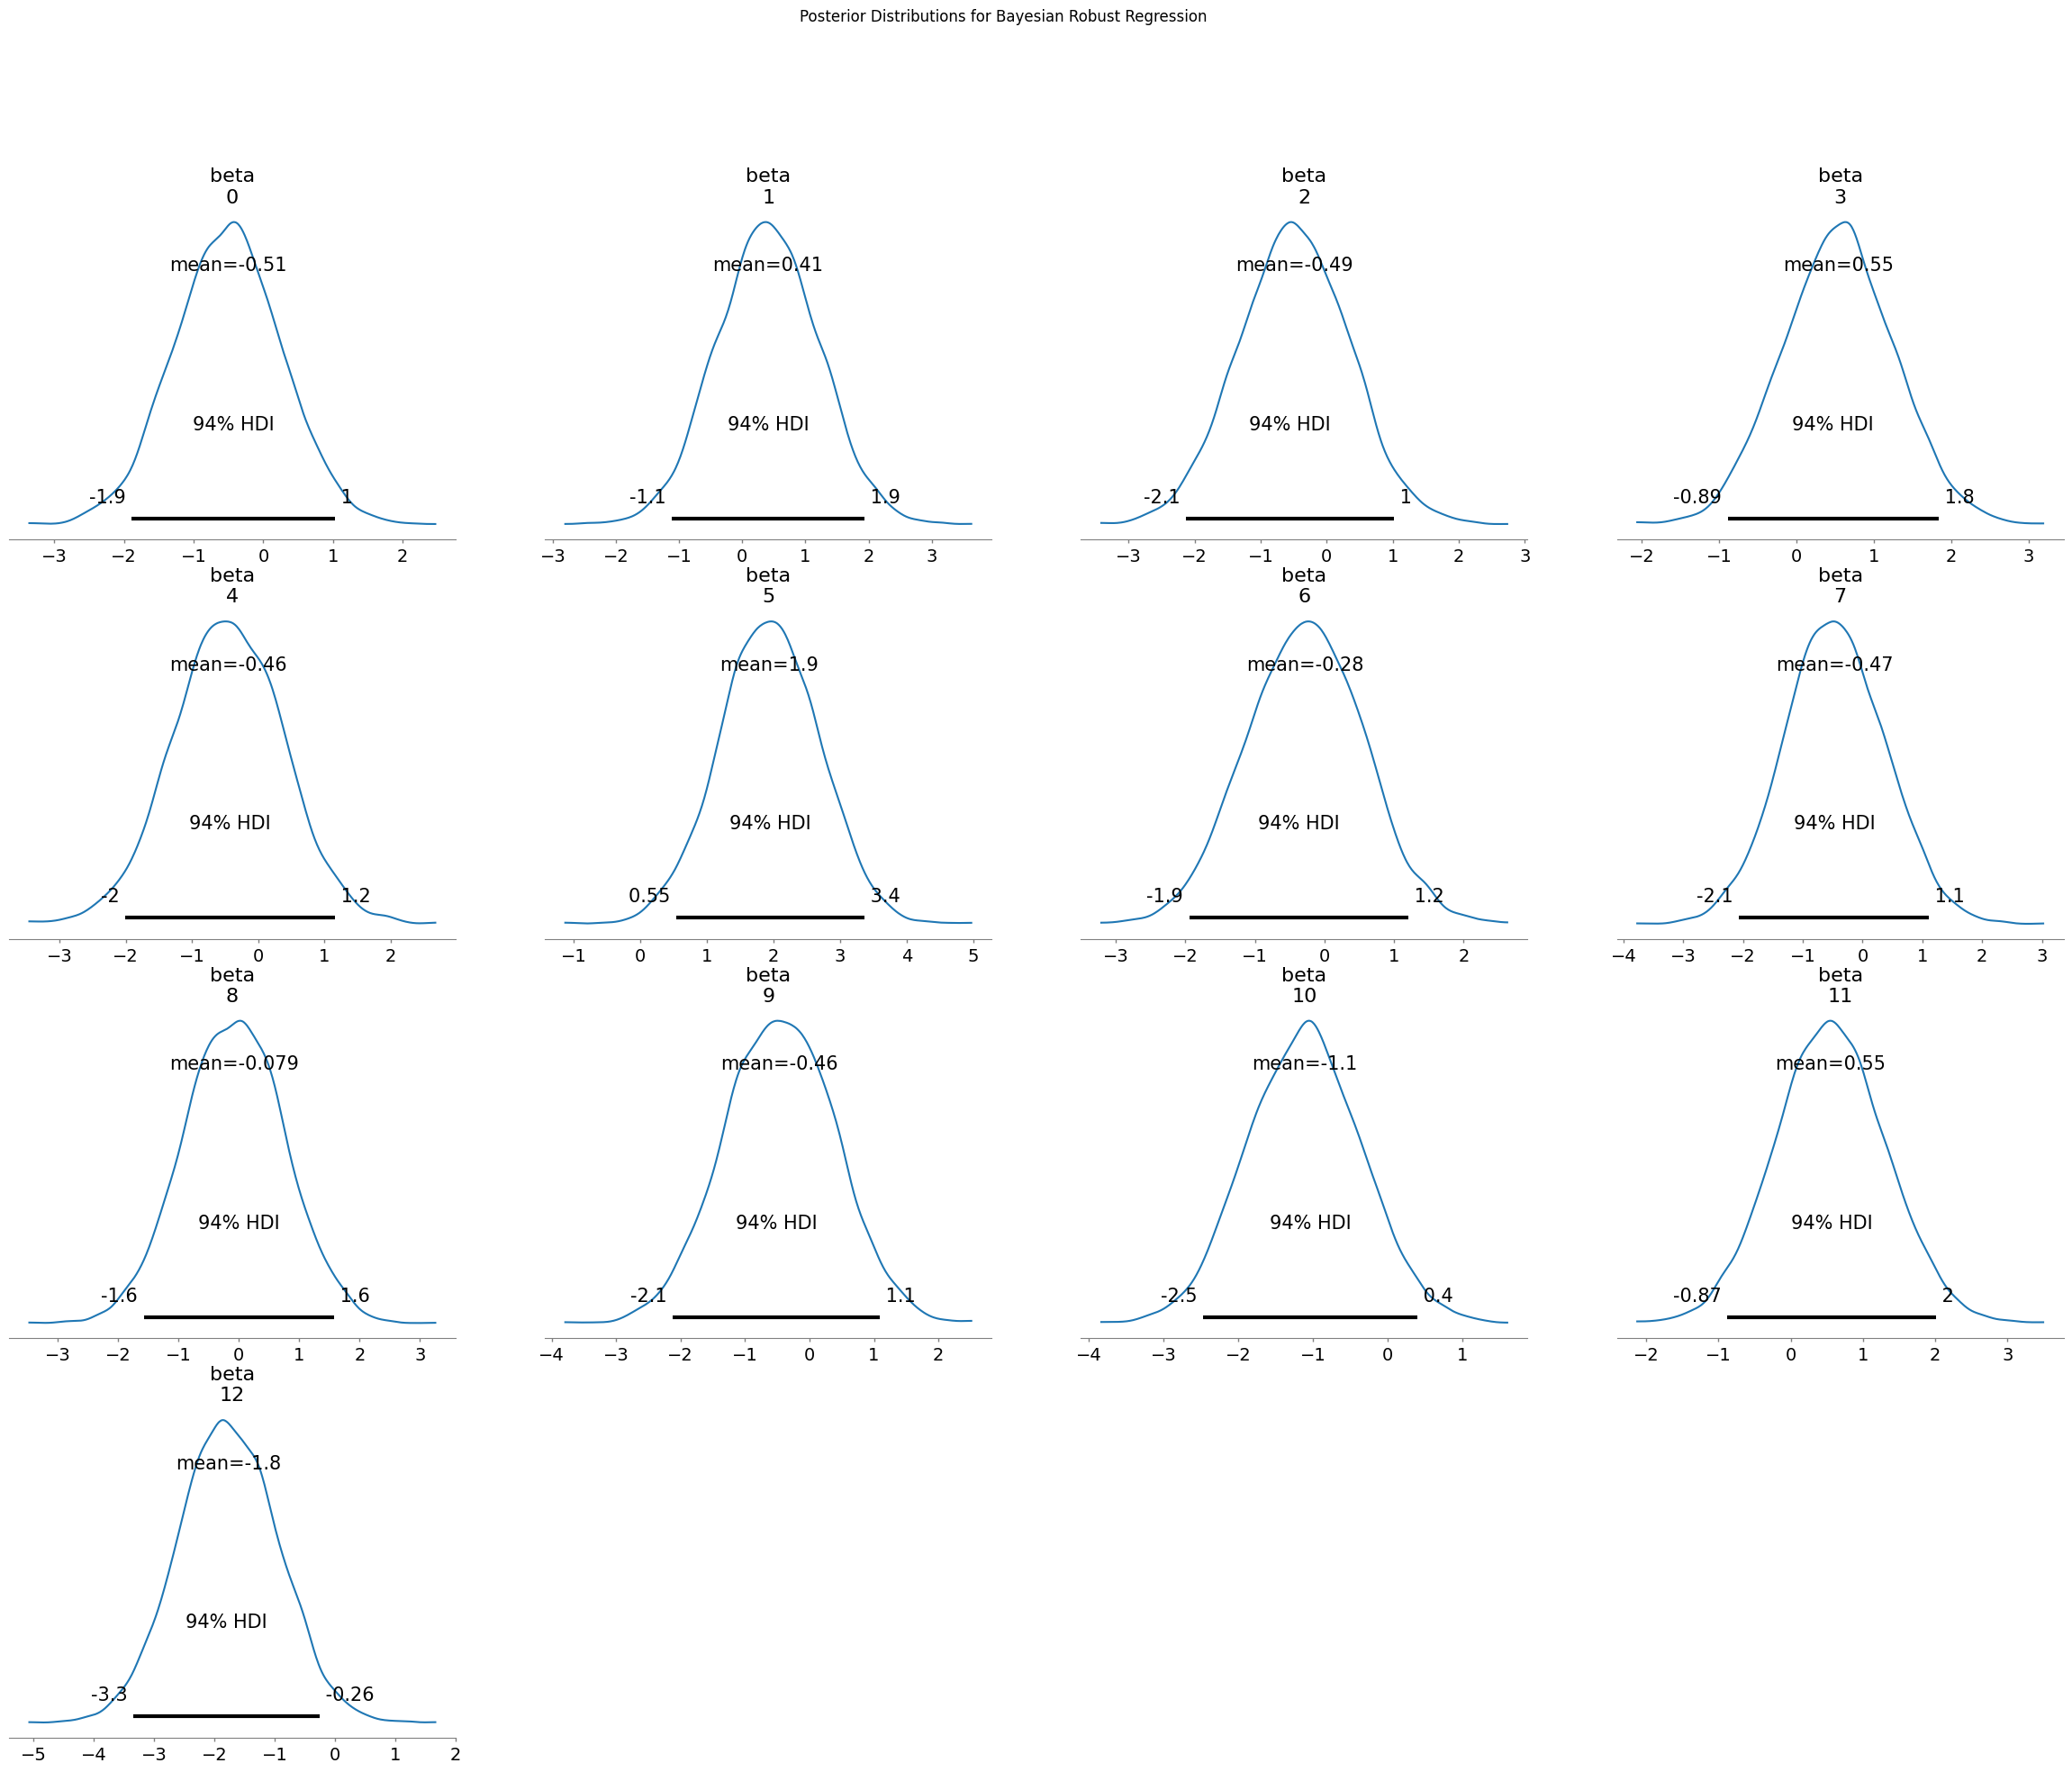

Running Bayesian Regression VI...


Output()

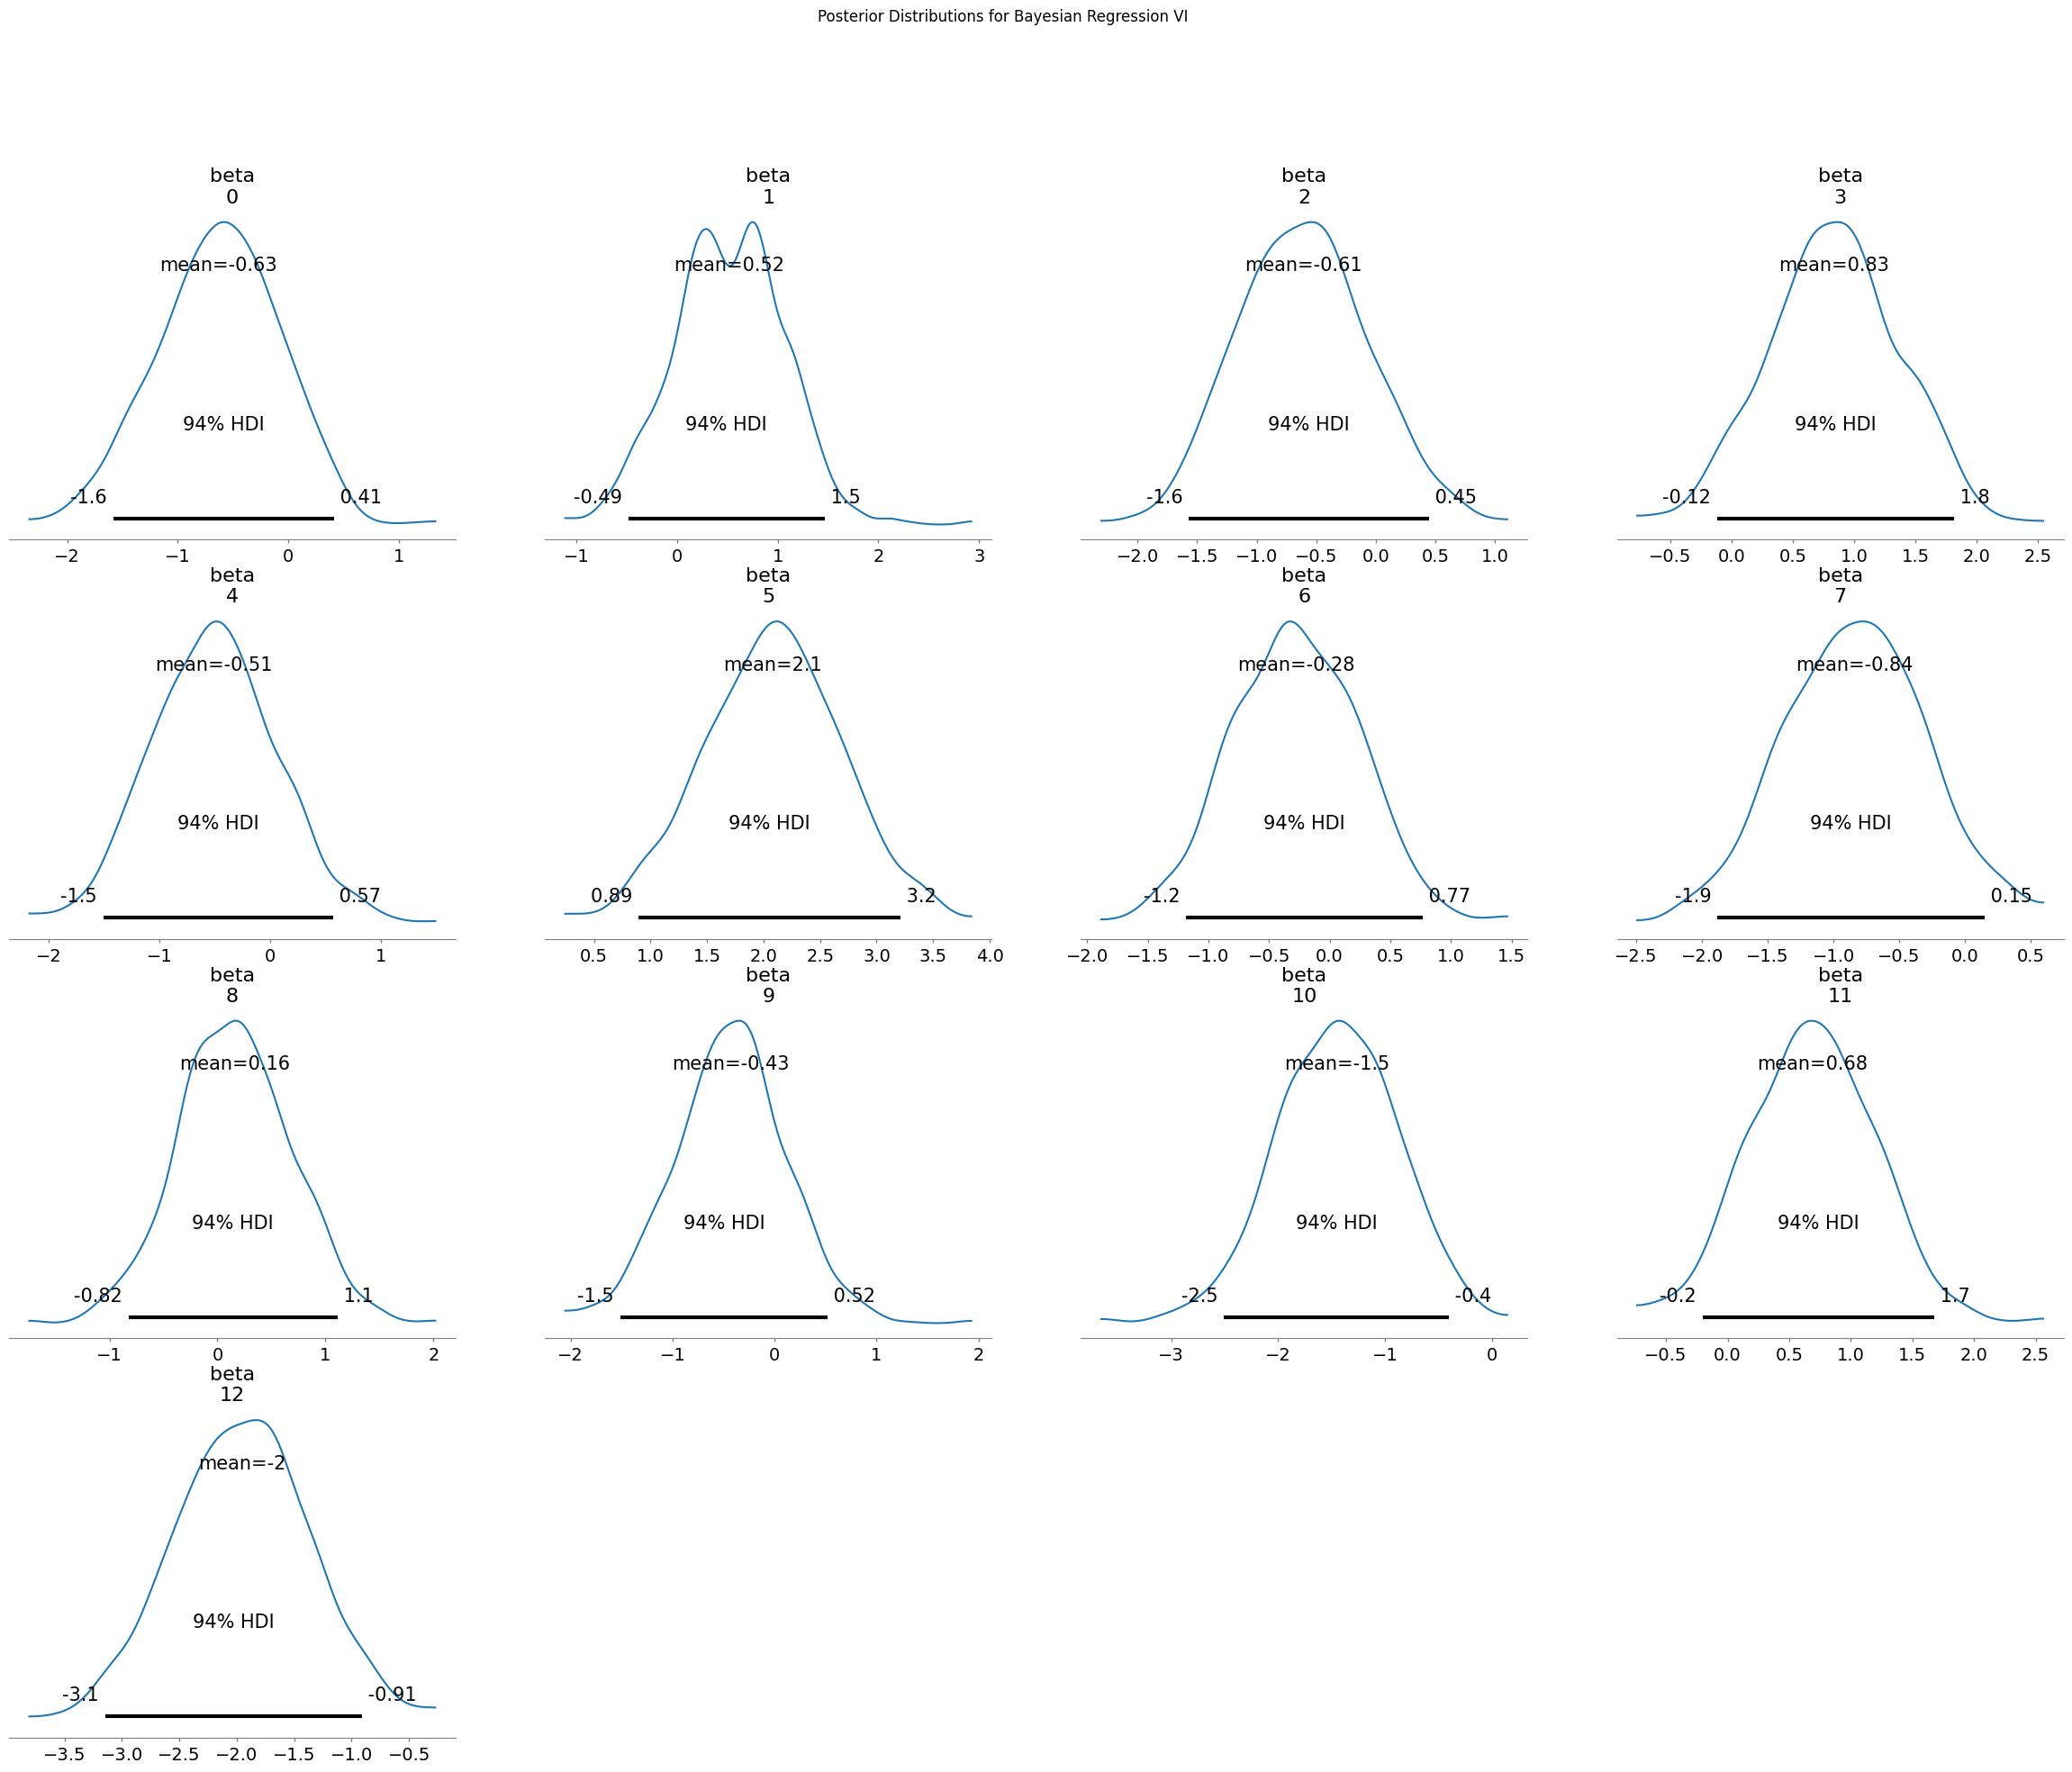


Model Performance Summary:
                        Model    Beta_1    Beta_2    Beta_3    Beta_4  \
0  Bayesian Linear Regression -0.510759  0.413279 -0.493205  0.576988   
1   Bayesian Ridge Regression -0.592347  0.497540 -0.460293  0.687917   
2  Bayesian Robust Regression -0.509026  0.409719 -0.491796  0.547260   
3      Bayesian Regression VI -0.630744  0.518214 -0.611307  0.832079   

     Beta_5    Beta_6    Beta_7    Beta_8    Beta_9   Beta_10   Beta_11  \
0 -0.448078  1.961539 -0.256490 -0.480581 -0.052612 -0.455675 -1.137767   
1 -0.685743  2.493378 -0.210646 -1.123116  0.342435 -0.523146 -1.445728   
2 -0.457311  1.938832 -0.284069 -0.470870 -0.078600 -0.464677 -1.114252   
3 -0.505766  2.081872 -0.277415 -0.837838  0.160131 -0.431303 -1.452301   

    Beta_12   Beta_13         MSE  
0  0.556735 -1.802145  539.139831  
1  0.689011 -2.453202  533.655058  
2  0.549687 -1.772703  539.436366  
3  0.684479 -1.955374  536.452349  


Model    Beta_1    Beta_2    Beta_3    Beta_4  \
0  Bayesian Linear Regression -0.510759  0.413279 -0.493205  0.576988   
1   Bayesian Ridge Regression -0.592347  0.497540 -0.460293  0.687917   
2  Bayesian Robust Regression -0.509026  0.409719 -0.491796  0.547260   
3      Bayesian Regression VI -0.630744  0.518214 -0.611307  0.832079   

     Beta_5    Beta_6    Beta_7    Beta_8    Beta_9   Beta_10   Beta_11  \
0 -0.448078  1.961539 -0.256490 -0.480581 -0.052612 -0.455675 -1.137767   
1 -0.685743  2.493378 -0.210646 -1.123116  0.342435 -0.523146 -1.445728   
2 -0.457311  1.938832 -0.284069 -0.470870 -0.078600 -0.464677 -1.114252   
3 -0.505766  2.081872 -0.277415 -0.837838  0.160131 -0.431303 -1.452301   

    Beta_12   Beta_13         MSE  
0  0.556735 -1.802145  539.139831  
1  0.689011 -2.453202  533.655058  
2  0.549687 -1.772703  539.436366  
3  0.684479 -1.955374  536.452349

In [46]:

# Load dataset
housing = pd.read_csv("https://raw.githubusercontent.com/javmencia/STA410/refs/heads/main/housing.csv", header=None, sep=r"\s+")
housing.columns = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"]

# Define X (predictors) and y (target variable)
X = housing.drop(columns=["MEDV"]).values
y = housing["MEDV"].values

# Normalize X
X = (X - X.mean(axis=0)) / X.std(axis=0)

def bayesian_regression_mcmc(X, y):
    with pm.Model() as model:
        beta = pm.MvNormal("beta", mu=np.zeros(X.shape[1]), chol=np.eye(X.shape[1]), shape=X.shape[1])
        sigma = pm.HalfCauchy("sigma", beta=2)
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        trace = pm.sample(4000, return_inferencedata=True)
    return model, trace

def bayesian_ridge_regression(X, y):
    with pm.Model() as model:
        tau = pm.HalfCauchy("tau", beta=1)
        beta = pm.MvNormal("beta", mu=np.zeros(X.shape[1]), cov=tau**2 * np.eye(X.shape[1]), shape=X.shape[1])
        sigma = pm.HalfCauchy("sigma", beta=2)
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        trace = pm.sample(4000, return_inferencedata=True)
    return model, trace

def bayesian_robust_regression(X, y):
    with pm.Model() as model:
        beta = pm.MvNormal("beta", mu=np.zeros(X.shape[1]), chol=np.eye(X.shape[1]), shape=X.shape[1])
        sigma = pm.HalfCauchy("sigma", beta=2)
        nu = pm.Exponential("nu", 1/30)
        mu = pm.math.dot(X, beta)
        y_obs = pm.StudentT("y_obs", nu=nu, mu=mu, sigma=sigma, observed=y)
        trace = pm.sample(4000, return_inferencedata=True)
    return model, trace

def bayesian_regression_vi(X, y):
    with pm.Model() as model:
        beta = pm.MvNormal("beta", mu=np.zeros(X.shape[1]), chol=np.eye(X.shape[1]), shape=X.shape[1])
        sigma = pm.HalfCauchy("sigma", beta=2)
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        approx = pm.fit(n=10000, method="advi")
    return model, approx.sample(1000)

def bayesian_pcr(X, y, n_components=None):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    with pm.Model() as model:
        beta = pm.MvNormal("beta", mu=np.zeros(X_pca.shape[1]), chol=np.eye(X_pca.shape[1]), shape=X_pca.shape[1])
        sigma = pm.HalfCauchy("sigma", beta=2)
        mu = pm.math.dot(X_pca, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        trace = pm.sample(4000, return_inferencedata=True)
    return model, trace

def run_and_plot_models(X, y, n_components=2):
    models = [bayesian_regression_mcmc, bayesian_ridge_regression, bayesian_robust_regression, bayesian_regression_vi]#, bayesian_pcr]
    model_names = ["Bayesian Linear Regression", "Bayesian Ridge Regression", "Bayesian Robust Regression", "Bayesian Regression VI"] #, "Bayesian PCR"]

    results = []
    pca = PCA(n_components=n_components)  # Define PCA transformation outside loop

    for model, name in zip(models, model_names):
        print(f"Running {name}...")

        # Fit the model
        if name == "Bayesian PCR":
            X_transformed = pca.fit_transform(X)  # Transform X using PCA
            mod, trace = model(X_transformed, y, n_components=n_components)
            X_used = X_transformed  # Use transformed data for prediction
        else:
            mod, trace = model(X, y)
            X_used = X  # Use original data for other models

        # Extract posterior mean for beta coefficients
        beta_means = trace.posterior["beta"].mean(dim=("chain", "draw")).values.flatten()

        # Generate predictions
        y_pred = np.dot(X_used, beta_means)  # Ensure correct shape

        # Compute performance metric (Mean Squared Error)
        mse = np.mean((y - y_pred) ** 2)

        # Store results
        results.append([name] + list(beta_means) + [mse])

        # Plot posterior distributions
        pm.plot_posterior(trace, var_names=["beta"])
        plt.suptitle(f"Posterior Distributions for {name}")
        plt.show()

    # Create DataFrame to display results
    coef_names = [f"Beta_{i+1}" for i in range(X_used.shape[1])]
    columns = ["Model"] + coef_names + ["MSE"]
    results_df = pd.DataFrame(results, columns=columns)

    print("\nModel Performance Summary:")
    print(results_df)

    return results_df


run_and_plot_models(X, y, n_components=2)


## Robust regression dataset
Soccer players market value

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Load dataset
soccer = pd.read_csv("https://raw.githubusercontent.com/javmencia/STA410/refs/heads/main/transfermarkt201718.csv", sep=";")

# Drop unnecessary columns
soccer = soccer.drop(columns=["Unnamed: 0", "player", "squad", "Season"])

# Define target variable
y = soccer["value"]
X = soccer.drop(columns=["value"])

# Identify numerical and categorical columns
num_features = X.select_dtypes(include=["number"]).columns
cat_features = X.select_dtypes(exclude=["number"]).columns

# Preprocessing pipeline
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

# Define Lasso model with cross-validation
lasso = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LassoCV(cv=5, random_state=42))
])

# Fit model
lasso.fit(X, y)

# Get feature names after transformation
cat_feature_names = lasso.named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoder"].get_feature_names_out(cat_features)
all_feature_names = np.concatenate([num_features, cat_feature_names])

# Get selected features
selected_features = all_feature_names[lasso.named_steps["model"].coef_ != 0]

print("Selected Features:", selected_features)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127661987105728.0, tolerance: 40333765302331.92
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136704463535488.0, tolerance: 40333765302331.92
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79261095519296.0, tolerance: 57512821697058.83
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarn

Selected Features: ['age' 'games' 'goals' 'assists' 'cards_yellow' 'npxg' 'shots_free_kicks'
 'shots_on_target_per90' 'goals_per_shot' 'goals_per_shot_on_target'
 'xg_net' 'npxg_net' 'passes_total_distance' 'passes_progressive_distance'
 'passes_pct_medium' 'passes_into_final_third' 'passes_into_penalty_area'
 'crosses_into_penalty_area' 'corner_kicks_in' 'passes_ground'
 'passes_oob' 'sca_passes_dead' 'sca_fouled' 'gca_passes_live'
 'gca_dribbles' 'gca_shots' 'gca_fouled' 'dribble_tackles_pct'
 'pressures_mid_3rd' 'pressures_att_3rd' 'blocked_shots' 'blocked_passes'
 'errors' 'touches_att_pen_area' 'dribbles_completed'
 'dribbles_completed_pct' 'miscontrols' 'dispossessed' 'cards_yellow_red'
 'aerials_lost' 'aerials_won_pct' 'clean_sheets' 'clean_sheets_pct'
 'psxg_net_gk' 'cards_yellowm' 'cards_redm' 'npxg_per90m'
 'shots_on_targetm' 'npxg_netm' 'passes_pctm' 'passes_free_kicksm'
 'passes_pressurem' 'corner_kicks_straightm' 'passes_right_footm'
 'throw_insm' 'passes_oobm' 'passes_int

Running Bayesian Linear Regression...


Output()

/usr/local/lib/python3.11/dist-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (81) in plot_posterior, generating only 40 plots
  warnings.warn(


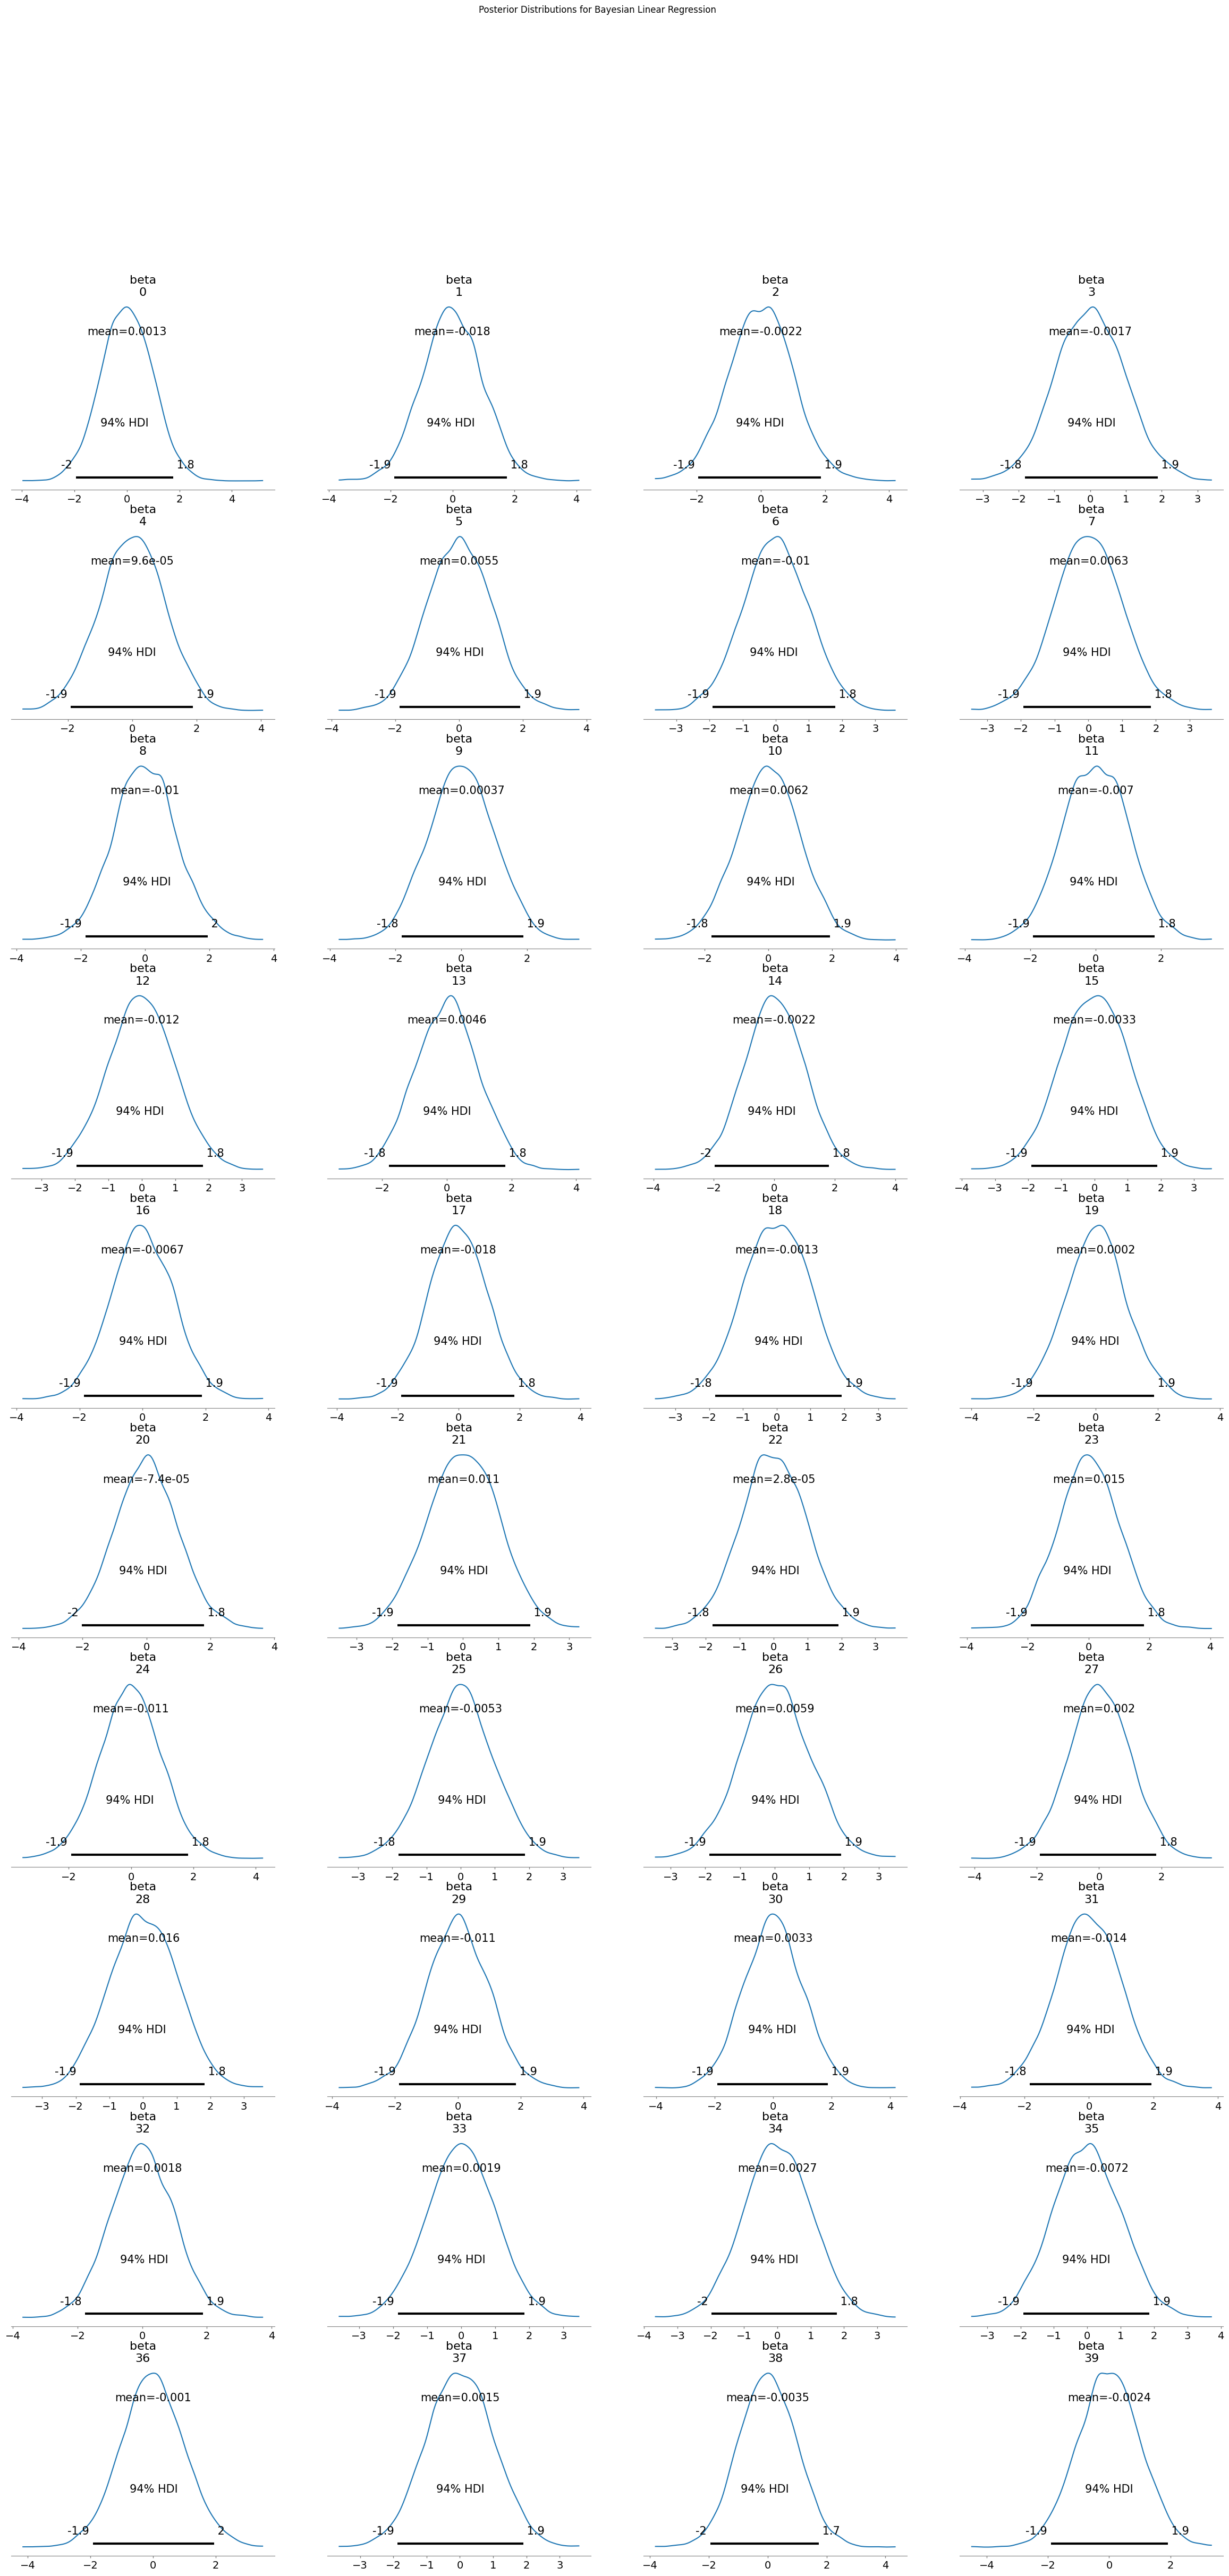

Running Bayesian Ridge Regression...


Output()

ERROR:pymc.stats.convergence:There were 721 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.11/dist-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (81) in plot_posterior, generating only 40 plots
  warnings.warn(


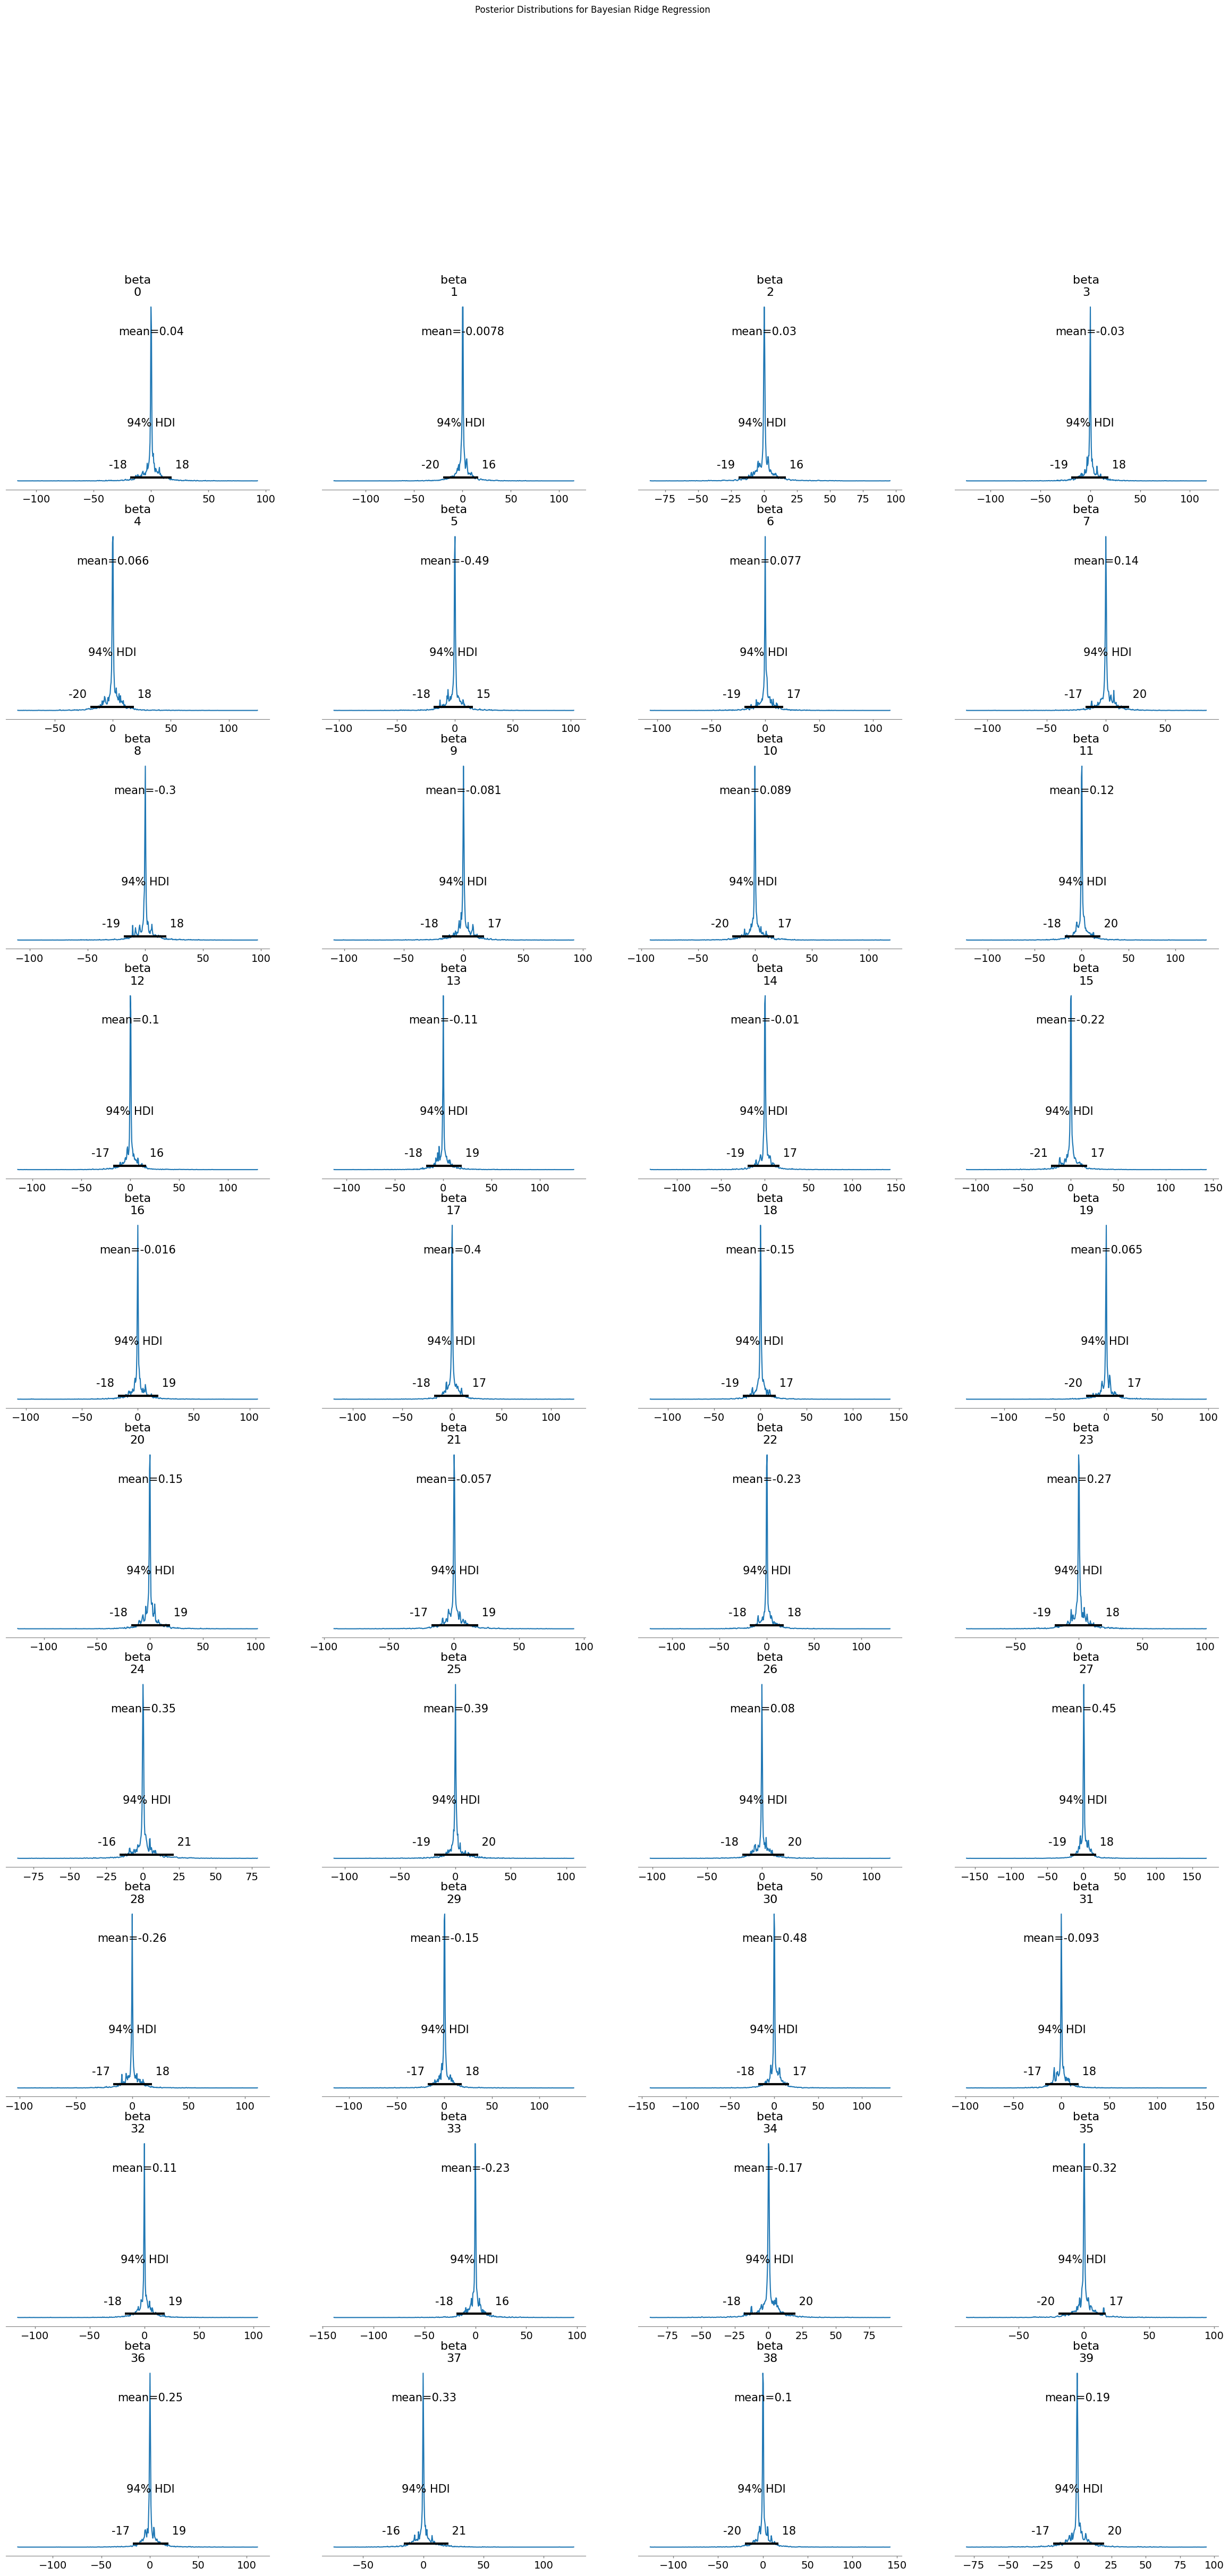

Running Bayesian Robust Regression...


Output()

/usr/local/lib/python3.11/dist-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (81) in plot_posterior, generating only 40 plots
  warnings.warn(


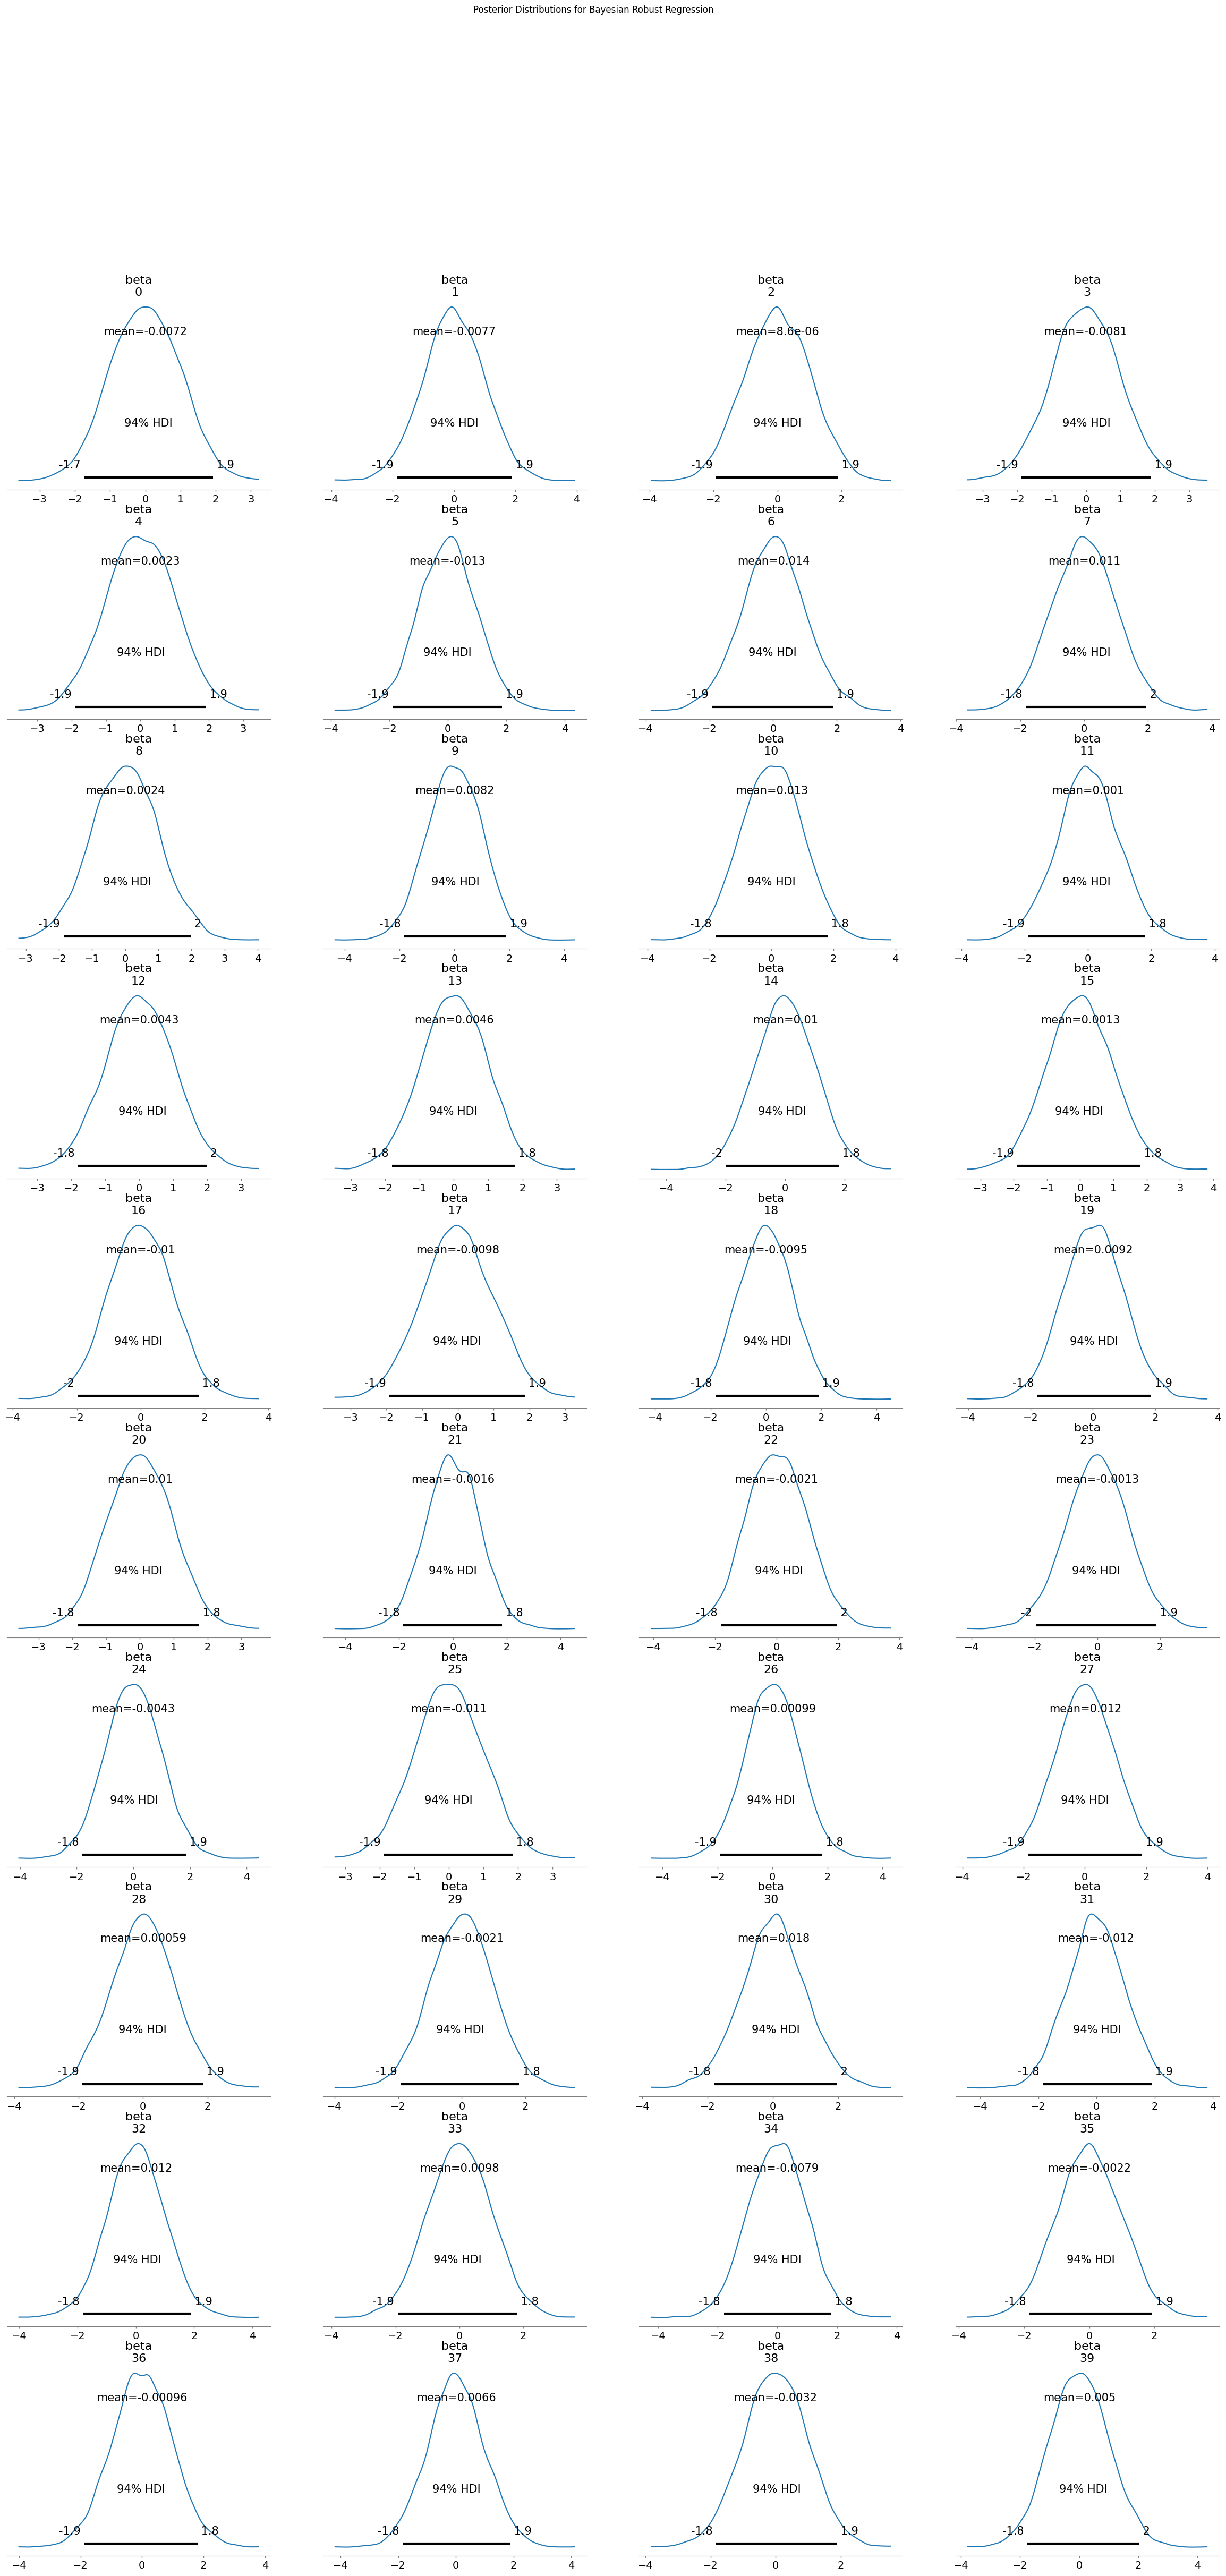

Running Bayesian Regression VI...


Output()

/usr/local/lib/python3.11/dist-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (81) in plot_posterior, generating only 40 plots
  warnings.warn(


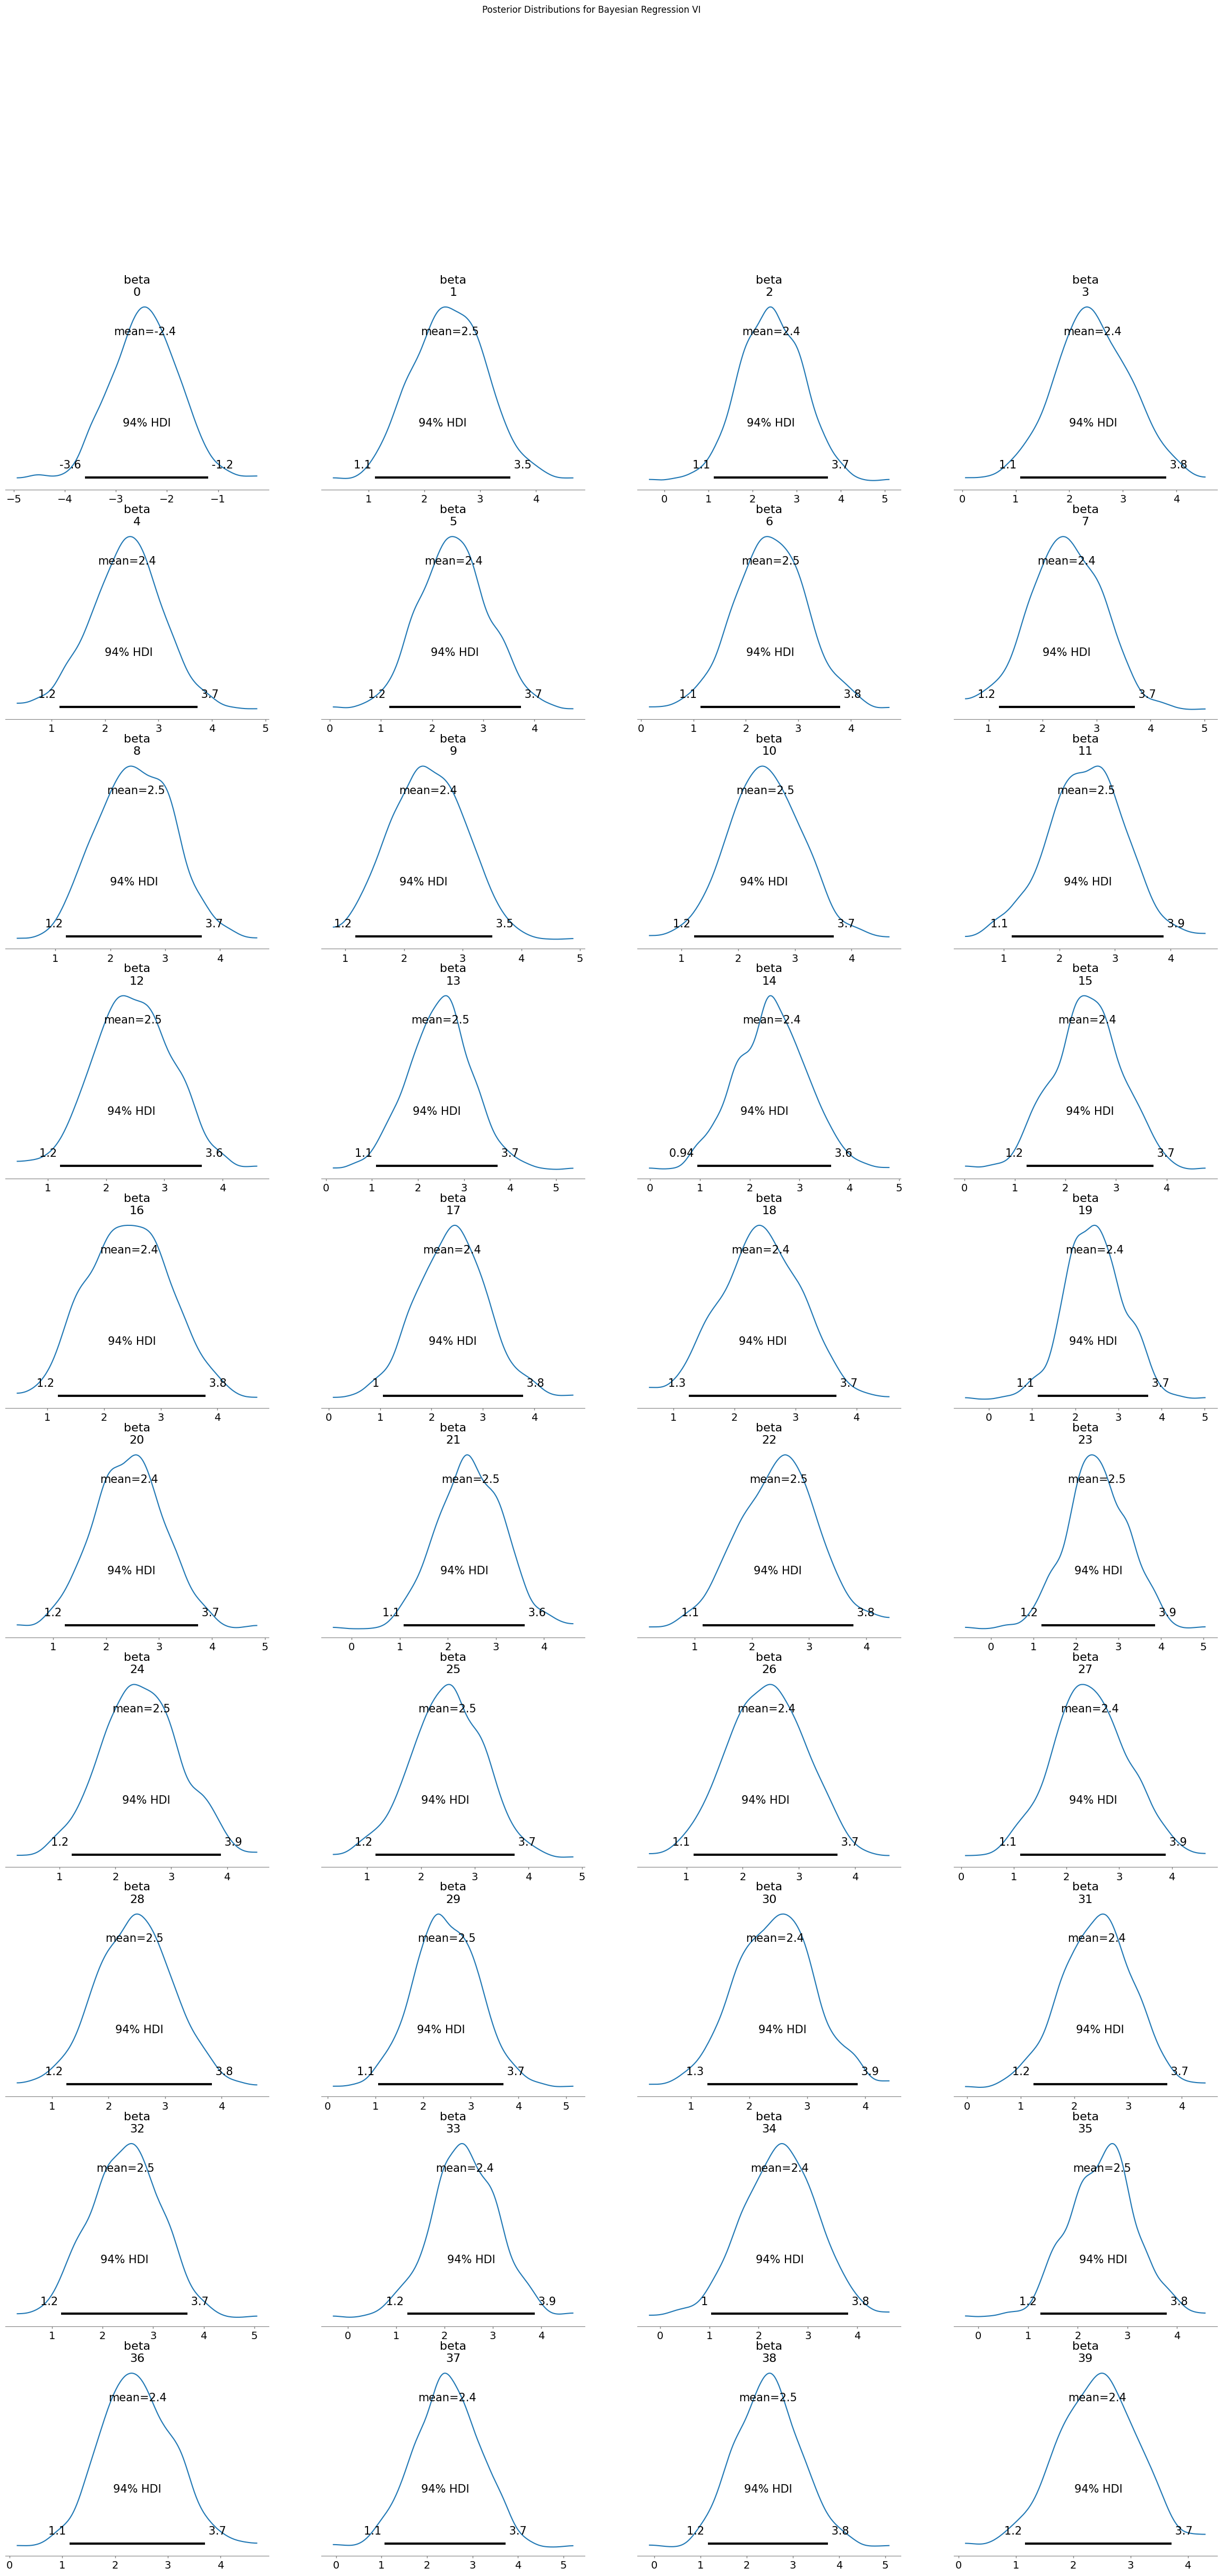


Model Performance Summary:
                        Model    Beta_1    Beta_2    Beta_3    Beta_4  \
0  Bayesian Linear Regression  0.001344 -0.017603 -0.002192 -0.001710   
1   Bayesian Ridge Regression  0.040087 -0.007819  0.029551 -0.029945   
2  Bayesian Robust Regression -0.007198 -0.007742  0.000009 -0.008134   
3      Bayesian Regression VI -2.439113  2.455787  2.425474  2.433360   

     Beta_5    Beta_6    Beta_7    Beta_8    Beta_9  ...   Beta_73   Beta_74  \
0  0.000096  0.005539 -0.010245  0.006331 -0.009996  ...  0.000884 -0.009390   
1  0.066027 -0.487832  0.076661  0.140849 -0.303564  ...  0.204837 -0.139267   
2  0.002290 -0.013434  0.014478  0.011361  0.002353  ... -0.003136  0.001301   
3  2.409514  2.422432  2.467910  2.444793  2.464754  ... -2.411518  2.459679   

    Beta_75   Beta_76   Beta_77   Beta_78   Beta_79   Beta_80   Beta_81  \
0 -0.004756 -0.013810  0.005488  0.002488 -0.004931  0.009624 -0.011867   
1  0.234958 -0.333019  0.280581  0.059386 -0.115473 -0.

Model    Beta_1    Beta_2    Beta_3    Beta_4  \
0  Bayesian Linear Regression  0.001344 -0.017603 -0.002192 -0.001710   
1   Bayesian Ridge Regression  0.040087 -0.007819  0.029551 -0.029945   
2  Bayesian Robust Regression -0.007198 -0.007742  0.000009 -0.008134   
3      Bayesian Regression VI -2.439113  2.455787  2.425474  2.433360   

     Beta_5    Beta_6    Beta_7    Beta_8    Beta_9  ...   Beta_73   Beta_74  \
0  0.000096  0.005539 -0.010245  0.006331 -0.009996  ...  0.000884 -0.009390   
1  0.066027 -0.487832  0.076661  0.140849 -0.303564  ...  0.204837 -0.139267   
2  0.002290 -0.013434  0.014478  0.011361  0.002353  ... -0.003136  0.001301   
3  2.409514  2.422432  2.467910  2.444793  2.464754  ... -2.411518  2.459679   

    Beta_75   Beta_76   Beta_77   Beta_78   Beta_79   Beta_80   Beta_81  \
0 -0.004756 -0.013810  0.005488  0.002488 -0.004931  0.009624 -0.011867   
1  0.234958 -0.333019  0.280581  0.059386 -0.115473 -0.082729  0.051005   
2  0.002849 -0.012784 -0.001436 -0.014605 -0.013259  0.000775 -0.010675   
3  2.450724  2.434627  2.428329  2.456405  2.466911 -2.441923  2.442050   

            MSE  
0  3.704428e+14  
1  3.704428e+14  
2  3.704428e+14  
3  3.704416e+14  

[4 rows x 83 columns]

In [12]:
# Transform X using the same preprocessing pipeline
X_transformed = preprocessor.fit_transform(X)

# Keep only selected features
X_selected = X_transformed[:, lasso.named_steps["model"].coef_ != 0]

# Normalize X
X_selected = (X_selected - X_selected.mean(axis=0)) / X_selected.std(axis=0)

# Run models with selected features
run_and_plot_models(X_selected, y)

### Before PCR

Running models for sample size: 50


Output()

Output()

ERROR:pymc.stats.convergence:There were 181 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Running models for sample size: 100


Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There were 215 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Running models for sample size: 500


Output()

Output()

ERROR:pymc.stats.convergence:There were 124 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models for sample size: 1000


Output()

Output()

ERROR:pymc.stats.convergence:There were 144 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models for sample size: 1500


Output()

Output()

ERROR:pymc.stats.convergence:There were 136 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

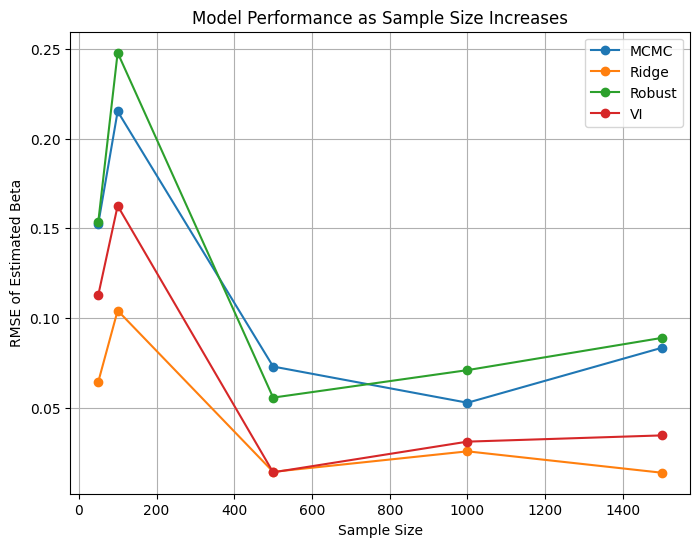

In [ ]:
# Define sample sizes to test
sample_sizes = [50, 100, 500, 1000, 1500]
rmse_results = {"MCMC": [], "Ridge": [], "Robust": [], "VI": [], "PCR" : []}

for n in sample_sizes:
    print(f"Running models for sample size: {n}")
    rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi, rmse_pcr = run_models_and_evaluate(n)
    rmse_results["MCMC"].append(rmse_mcmc)
    rmse_results["Ridge"].append(rmse_ridge)
    rmse_results["Robust"].append(rmse_robust)
    rmse_results["VI"].append(rmse_vi)
    rmse_results["PCR"].append(rmse_pcr)

# Plot RMSE as a function of sample size
plt.figure(figsize=(8, 6))
for model, rmse in rmse_results.items():
    plt.plot(sample_sizes, rmse, marker='o', label=model)
plt.xlabel("Sample Size")
plt.ylabel("RMSE of Estimated Beta")
plt.title("Model Performance as Sample Size Increases")
plt.legend()
plt.grid()
plt.show()

Running models for this many parameters: 5
[1.         1.18920712 1.41421356 1.68179283 2.        ]
[[0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]]
[6.34313041 8.23862283 3.40327589 6.55677829 2.70763078 7.86717578
 2.55954932 6.91704153 3.04405375 7.51581882 0.98431795 6.06781911
 2.29043936 7.84471689 2.60464811 7.64656651 2.56546417 8.03525878
 4.57115549 6.11193809]


Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There were 21 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models for this many parameters: 10
[1.         1.08005974 1.16652904 1.25992105 1.36079    1.46973449
 1.58740105 1.71448797 1.85174942 2.        ]
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[14.17123287 13.45095174 11.80316809 13.9593039   9.36397084 12.84057616
 10.05979643 13.91879166  5.86469927 14.33416863  6.37577213 14.257566
  6.51794212 15.60022719  7.40053405 1

Output()

ERROR:pymc.stats.convergence:There were 33 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models for this many parameters: 15
[1.         1.05075664 1.10408951 1.16012939 1.21901365 1.28088669
 1.34590019 1.41421356 1.48599429 1.56141836 1.64067071 1.72394564
 1.81144733 1.90339031 2.        ]
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1.

Output()

ERROR:pymc.stats.convergence:There were 26 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models for this many parameters: 20
[1.         1.03715504 1.07569059 1.11565792 1.15711024 1.20010272
 1.24469259 1.2909392  1.3389041  1.38865114 1.44024654 1.49375896
 1.54925964 1.60682245 1.66652401 1.72844379 1.79266419 1.85927071
 1.928352   2.        ]
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

Output()

ERROR:pymc.stats.convergence:There were 46 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

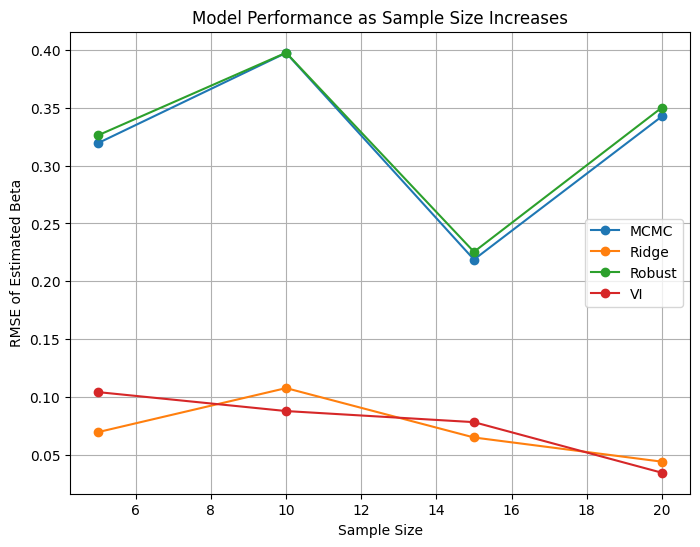

In [ ]:
# Define sample sizes to test
p_numbers = [5, 10, 15, 20]
n=20
rmse_results = {"MCMC": [], "Ridge": [], "Robust": [], "VI": []}

for p in p_numbers:
    print(f"Running models for this many parameters: {p}")
    rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi = run_models_and_evaluate(p)
    rmse_results["MCMC"].append(rmse_mcmc)
    rmse_results["Ridge"].append(rmse_ridge)
    rmse_results["Robust"].append(rmse_robust)
    rmse_results["VI"].append(rmse_vi)

# Plot RMSE as a function of sample size
plt.figure(figsize=(8, 6))
for model, rmse in rmse_results.items():
    plt.plot(p_numbers, rmse, marker='o', label=model)
plt.xlabel("Number of Predictors")
plt.ylabel("RMSE of Estimated Beta")
plt.title("Model Performance as Number of Predictors Increases")
plt.legend()
plt.grid()
plt.show()

Running models with true_beta: [1, 1, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 235 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Running models with true_beta: [1, 1.4142135623730951, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 148 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models with true_beta: [1, 4, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 557 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Running models with true_beta: [1, 8, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 54 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models with true_beta: [1, 16, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 420 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

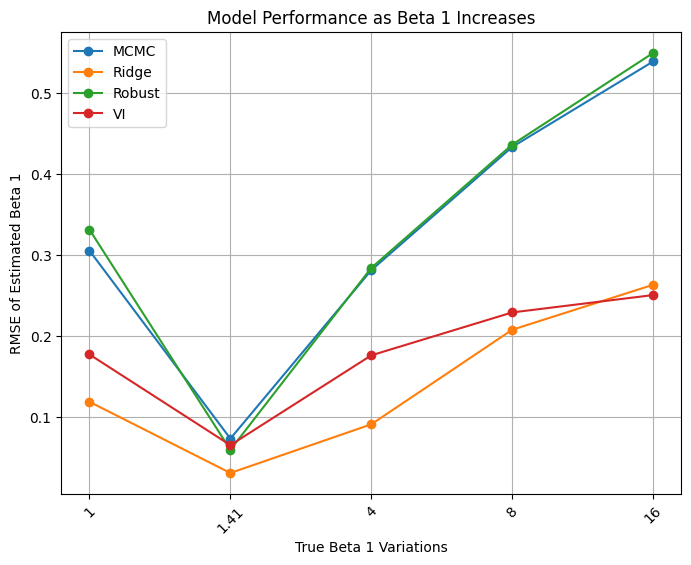

In [ ]:
# Define different values where only one coefficient increases at a time
beta_variations = [
    [1, 1, 2],
    [1, float(np.sqrt(2)), 2],
    [1, 4, 2],
    [1, 8, 2],
    [1, 16, 2]
]

n = 20
rmse_results = {"MCMC": [], "Ridge": [], "Robust": [], "VI": []}

for true_beta in beta_variations:
    print(f"Running models with true_beta: {true_beta}")
    rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi = run_models_and_evaluate(n = n, true_beta = true_beta)
    rmse_results["MCMC"].append(rmse_mcmc)
    rmse_results["Ridge"].append(rmse_ridge)
    rmse_results["Robust"].append(rmse_robust)
    rmse_results["VI"].append(rmse_vi)

# Plot RMSE as a function of increasing individual beta values
plt.figure(figsize=(8, 6))
beta_labels = [
    "1", "1.41", "4", "8", "16"
]
for model, rmse in rmse_results.items():
    plt.plot(beta_labels, rmse, marker='o', label=model)
plt.xlabel("True Beta 1 Variations")
plt.ylabel("RMSE of Estimated Beta 1")
plt.title("Model Performance as Beta 1 Increases")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


Running models with true_beta: [1, 1.4142135623730951, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 186 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models with true_beta: [2, 1.4142135623730951, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 391 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Running models with true_beta: [4, 1.4142135623730951, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 113 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models with true_beta: [8, 1.4142135623730951, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 206 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Running models with true_beta: [32, 1.4142135623730951, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 23 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

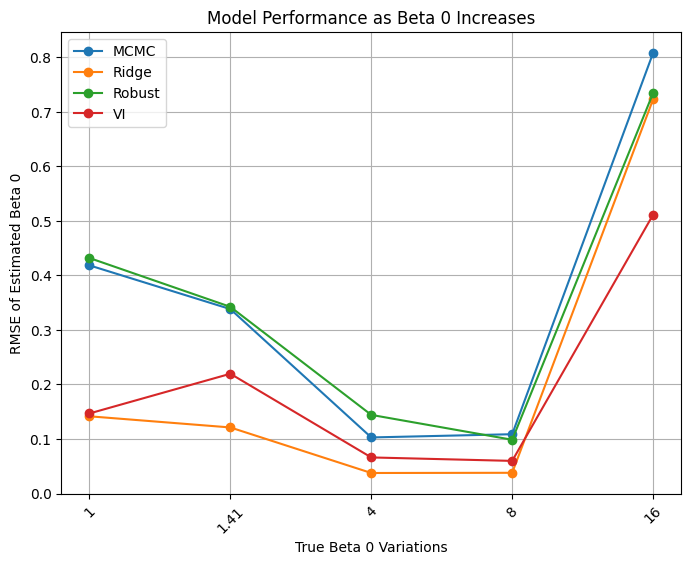

In [ ]:
# Define different values where only one coefficient increases at a time
beta_variations = [
    [1, float(np.sqrt(2)), 2],
    [2, float(np.sqrt(2)), 2],
    [4, float(np.sqrt(2)), 2],
    [8, float(np.sqrt(2)), 2],
    [32, float(np.sqrt(2)), 2]
]

n = 20
rmse_results = {"MCMC": [], "Ridge": [], "Robust": [], "VI": []}

for true_beta in beta_variations:
    print(f"Running models with true_beta: {true_beta}")
    rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi = run_models_and_evaluate(n = n, true_beta = true_beta)
    rmse_results["MCMC"].append(rmse_mcmc)
    rmse_results["Ridge"].append(rmse_ridge)
    rmse_results["Robust"].append(rmse_robust)
    rmse_results["VI"].append(rmse_vi)

# Plot RMSE as a function of increasing individual beta values
plt.figure(figsize=(8, 6))
beta_labels = [
    "1", "1.41", "4", "8", "16"
]
for model, rmse in rmse_results.items():
    plt.plot(beta_labels, rmse, marker='o', label=model)
plt.xlabel("True Beta 0 Variations")
plt.ylabel("RMSE of Estimated Beta 0")
plt.title("Model Performance as Beta 0 Increases")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()
